# Tracking the Growth of COVID-19 Cases in Global 

The purpose of this notebook is to infer the rate at which confirmed cases of COVID-19 are growing (or were growing) in various countries.

**The notebook pulls data from the Johns Hopkins [Data Repository](https://github.com/CSSEGISandData/COVID-19) of global Coronavirus COVID-19 cases**, and then does the following things:

- List cumulative number of confirmed cases (in countries with at least 100 confirmed cases)
- Attempt to fit the time series of cumulative confirmed cases to both an exponential and a logistic function
- Use these curve fits to infer doubling times (i.e., time for the number of cumulative confirmed cases to double)

We then repeat these steps for US states.

The notebook is updated approximately daily.

For a great primer on exponential and logistic growth, watch [this video](https://www.youtube.com/watch?v=Kas0tIxDvrg).

## Important Caveats:

- The growth rate (and the doubling time) changes with time. As the exponential curve eventually turns into a logistic curve, the growth rate will shrink to zero (& the doubling time will consequently increase). **So it's not a good idea to extrapolate trends far into the future based on current growth rates or doubling times.**

- The confirmed cases reported by each country are not the number of infections in each country, only those that have tested positive.

- The doubling time calculated here measures the growth of cumulative confirmed cases, which is different from the growth of infections. For example, if a country suddenly ramps up testing, then the number of confirmed cases will rapidly rise, but infections may not be rising as the same rate.

- The doubling times inferred from the curve fits are not necessarily the current or most recent doubling times: 
    - For countries where the growth is still exponential, the inferred doubling time gives us a picture of the overall rate of growth. 
    - For countries where the growth is no longer exponential, and the number of cases is stabilizing (such as China and South Korea), we use a logistic function to fit the data instead. Here, the inferred doubling time represents the growth encountered during the middle of the growth of the epidemic. 
    - Finally, we compare these values to the recent doubling time, calculated from the most recent week of data.

In [1]:
# Now
! date

2020年  4月 10日 金曜日 20:16:51 JST


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from termcolor import colored, cprint

import plotly.graph_objects as go
#import plotly.offline as offline
#offline.init_notebook_mode(connected=True)

In [3]:
datadir = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/'
df = pd.read_csv( datadir + 'time_series_covid19_confirmed_global.csv')
#df = pd.read_csv( datadir + 'time_series_covid19_deaths_global.csv')

## Global COVID-19 Analysis

In [4]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
cases.head()


Total number of cases (in countries with at least 100 cases) as of 4/9/20


4/9/20
Country/Region        
US              461437
Spain           153222
Italy           143626
France          118781
Germany         118181

## Curve Fitting Global COVID-19 Cases

In [5]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country, maxfev=100000, use_plotly=False):
#def plotCases(dataframe, column, country, maxfev=1):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    if(use_plotly is False):
        plt.figure(figsize=(10,5))
        plt.plot(x, y, 'ko', label="Original Data")
    else:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=x, y=y, mode='markers', name='Original Data'))
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=maxfev)
        lerror = np.sqrt(np.diag(lpcov))

        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])

        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  

        if logisticr2 > 0.95:
            if(use_plotly is False):
                plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            else:
                fig.add_trace(go.Scatter(x=x, y=logistic(x, *lpopt), mode='lines', line=dict(dash='dot'), name="Logistic Curve Fit") )
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            print("\tparam: ", lpopt)
            logisticworked = True
        else:
            print("\n logistic R^2 ", logisticr2)    
    except Exception as ex:
        cprint('\nException in logstic process ', 'red')
        cprint(type(ex), 'red')
        cprint(ex, 'red')
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=maxfev)
        eerror = np.sqrt(np.diag(epcov))

        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])

        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)

        if expr2 > 0.95:
            if(use_plotly is False):
                plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            else:
                fig.add_trace(go.Scatter(x=x, y=exponential(x, *epopt), mode='lines', line=dict(dash='dot'), name="Exponential Curve Fit"))
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            print("\tparam: ", epopt)
            exponentialworked = True
        else:
            print("\n exponential R^2 ", expr2)    
    except Exception as ex:
        cprint('\nException in exponential process ', 'red')
        cprint(type(ex), 'red')
        cprint(ex, 'red')
    
    if(use_plotly == False):
        plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
        plt.xlabel('Days', fontsize="x-large")
        plt.ylabel('Total Cases', fontsize="x-large")
        plt.legend(fontsize="x-large")
        plt.show()
    else:
        fig.update_layout(title=country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')'
                          ,  xaxis_title='Days'
                          , yaxis_title='Total Cases'
                          , width=900, height=700,  autosize=False
                          #,paper_bgcolor='black'
                         )
        fig.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



US

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 461437
	Confirmed cases on 4/2/20 	 243762
	Ratio: 1.89
	Weekly increase: 89.3 %
	Daily increase: 9.5 % per day
	Doubling Time (represents recent growth): 7.6 days

** Based on Logistic Fit**

	R^2: 0.999457379147097
	Doubling Time (during middle of growth):  6.49 (± 0.18 ) days
	param:  [ 5.62239191e+06  2.13758661e-01 -9.55370419e+02  5.99993774e+05]

** Based on Exponential Fit **

	R^2: 0.9851324250825383
	Doubling Time (represents overall growth):  5.65 (± 0.33 ) days
	param:  [  35.80427868    0.12258102 -100.        ]


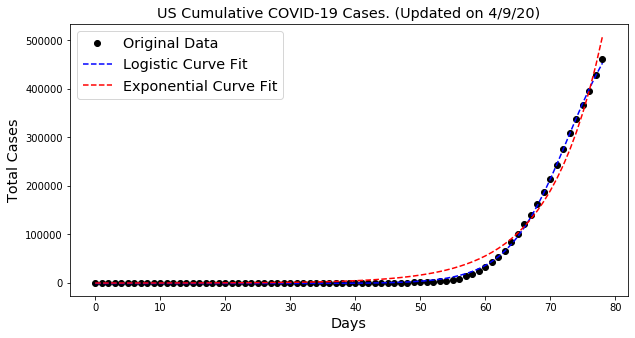



Spain

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 153222
	Confirmed cases on 4/2/20 	 112065
	Ratio: 1.37
	Weekly increase: 36.7 %
	Daily increase: 4.6 % per day
	Doubling Time (represents recent growth): 15.5 days

** Based on Logistic Fit**

	R^2: 0.9996268473722169
	Doubling Time (during middle of growth):  6.84 (± 0.16 ) days
	param:  [ 1.14142241e+05  2.02607093e-01 -4.09179497e+02  1.68284864e+05]

 exponential R^2  0.9467432193090242


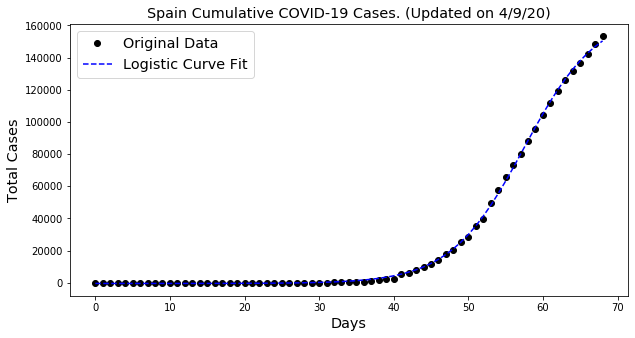



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 143626
	Confirmed cases on 4/2/20 	 115242
	Ratio: 1.25
	Weekly increase: 24.6 %
	Daily increase: 3.2 % per day
	Doubling Time (represents recent growth): 22.0 days

** Based on Logistic Fit**

	R^2: 0.9992450079021372
	Doubling Time (during middle of growth):  8.8 (± 0.28 ) days
	param:  [ 5.24877350e+03  1.57489853e-01 -8.52685269e+02  1.53645049e+05]

 exponential R^2  0.8494194111773343


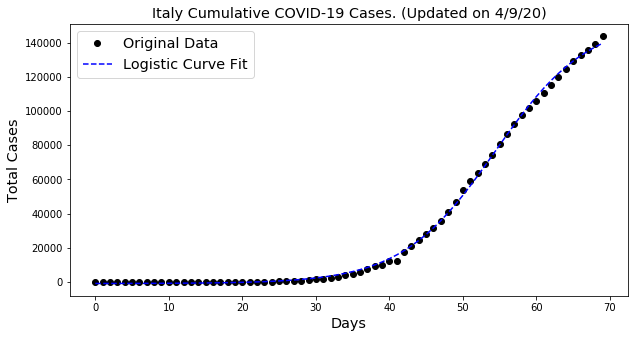



France

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 118781
	Confirmed cases on 4/2/20 	 59929
	Ratio: 1.98
	Weekly increase: 98.2 %
	Daily increase: 10.3 % per day
	Doubling Time (represents recent growth): 7.1 days

** Based on Logistic Fit**

	R^2: 0.9959734456628644
	Doubling Time (during middle of growth):  8.93 (± 0.71 ) days
	param:  [ 1.00199893e+05  1.55300702e-01 -2.08653545e+02  2.14937196e+05]

** Based on Exponential Fit **

	R^2: 0.9897444994126118
	Doubling Time (represents overall growth):  6.39 (± 0.32 ) days
	param:  [  34.71698865    0.10845863 -100.        ]


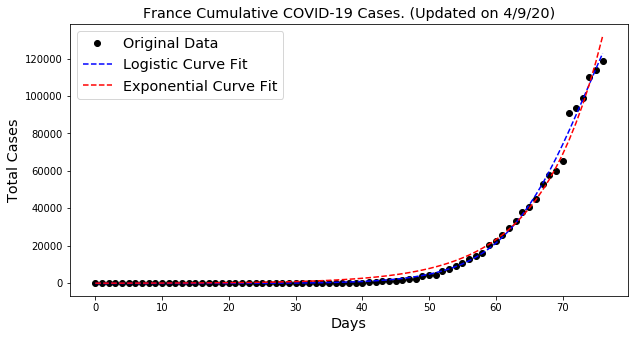



Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 118181
	Confirmed cases on 4/2/20 	 84794
	Ratio: 1.39
	Weekly increase: 39.4 %
	Daily increase: 4.9 % per day
	Doubling Time (represents recent growth): 14.6 days

** Based on Logistic Fit**

	R^2: 0.9992483236129874
	Doubling Time (during middle of growth):  7.33 (± 0.23 ) days
	param:  [ 1.42680117e+05  1.89225808e-01 -3.75329663e+02  1.31714265e+05]

** Based on Exponential Fit **

	R^2: 0.9640667874342526
	Doubling Time (represents overall growth):  6.97 (± 0.68 ) days
	param:  [ 1.00000000e+02  9.94806791e-02 -1.00000000e+02]


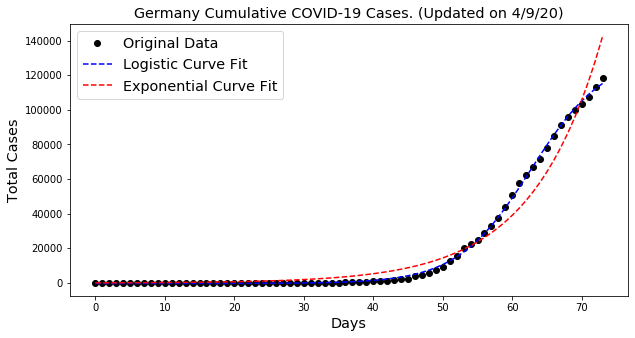



China

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 82883
	Confirmed cases on 4/2/20 	 82432
	Ratio: 1.01
	Weekly increase: 0.5 %
	Daily increase: 0.1 % per day
	Doubling Time (represents recent growth): 889.3 days

** Based on Logistic Fit**

	R^2: 0.9958424653559013
	Doubling Time (during middle of growth):  6.61 (± 0.46 ) days
	param:  [ 4.00099282e+01  2.09762935e-01 -1.67617702e+03  8.15829733e+04]

 exponential R^2  -2.5264847667101678


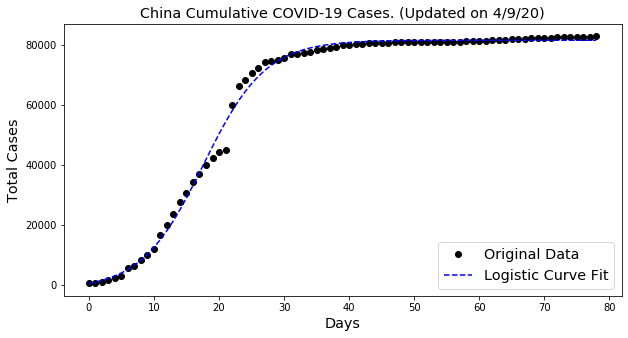



Iran

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 66220
	Confirmed cases on 4/2/20 	 50468
	Ratio: 1.31
	Weekly increase: 31.2 %
	Daily increase: 4.0 % per day
	Doubling Time (represents recent growth): 17.9 days

** Based on Logistic Fit**

	R^2: 0.9974391794730995
	Doubling Time (during middle of growth):  14.86 (± 1.65 ) days
	param:  [ 7.25440041e+01  9.33075376e-02 -2.32802681e+03  1.16304084e+05]

 exponential R^2  0.7374062674738822


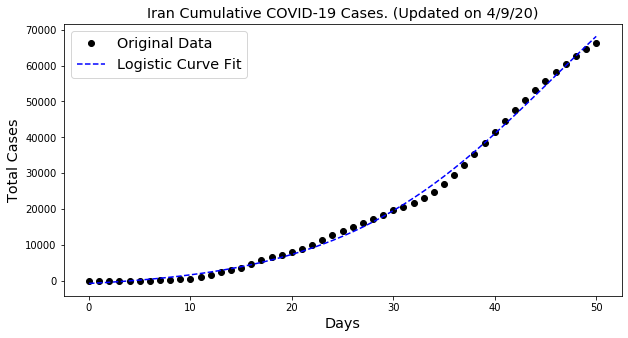



United Kingdom

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 65872
	Confirmed cases on 4/2/20 	 34173
	Ratio: 1.93
	Weekly increase: 92.8 %
	Daily increase: 9.8 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.9997398733851841
	Doubling Time (during middle of growth):  7.11 (± 0.15 ) days
	param:  [ 3.19186922e+05  1.94971933e-01 -7.62654383e+01  9.55030324e+04]

** Based on Exponential Fit **

	R^2: 0.9897775260046264
	Doubling Time (represents overall growth):  5.73 (± 0.3 ) days
	param:  [  17.12832204    0.12091878 -100.        ]


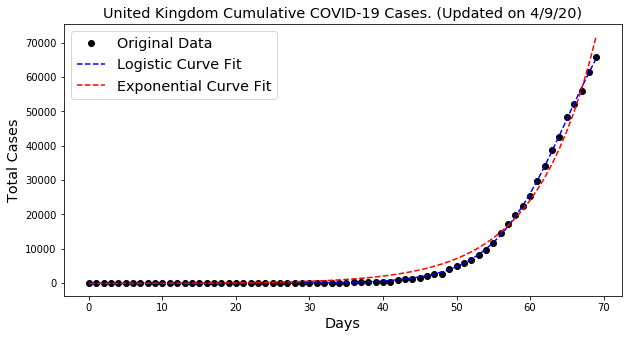



Turkey

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 42282
	Confirmed cases on 4/2/20 	 18135
	Ratio: 2.33
	Weekly increase: 133.2 %
	Daily increase: 12.9 % per day
	Doubling Time (represents recent growth): 5.7 days

** Based on Logistic Fit**

	R^2: 0.9983375817797348
	Doubling Time (during middle of growth):  6.41 (± 0.62 ) days
	param:  [ 2.96260438e+02  2.16300526e-01 -7.98599933e+02  6.51726273e+04]

 exponential R^2  0.9191613296062273


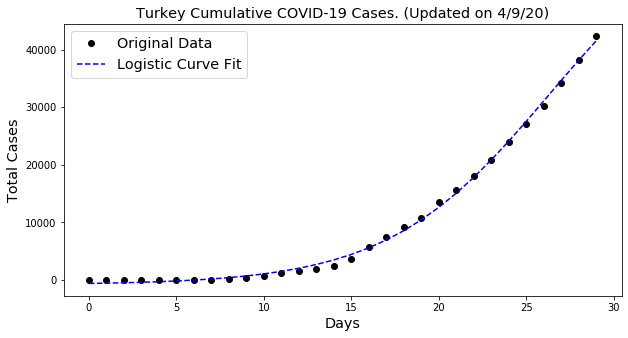



Belgium

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 24983
	Confirmed cases on 4/2/20 	 15348
	Ratio: 1.63
	Weekly increase: 62.8 %
	Daily increase: 7.2 % per day
	Doubling Time (represents recent growth): 10.0 days

** Based on Logistic Fit**

	R^2: 0.9990727637530953
	Doubling Time (during middle of growth):  7.04 (± 0.27 ) days
	param:  [ 8.45025969e+04  1.97010128e-01 -3.99862708e+01  3.00456518e+04]

** Based on Exponential Fit **

	R^2: 0.9803345946990341
	Doubling Time (represents overall growth):  6.77 (± 0.53 ) days
	param:  [  35.86849285    0.10243558 -100.        ]


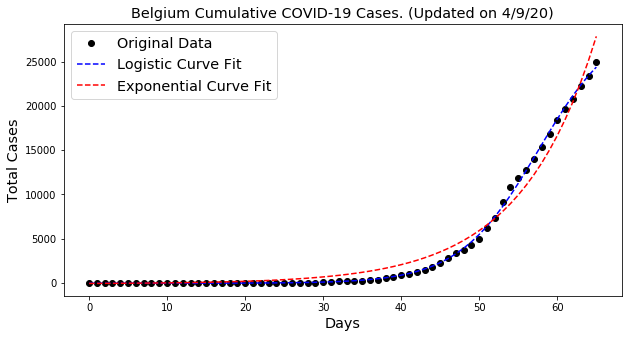



Switzerland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 24051
	Confirmed cases on 4/2/20 	 18827
	Ratio: 1.28
	Weekly increase: 27.7 %
	Daily increase: 3.6 % per day
	Doubling Time (represents recent growth): 19.8 days

** Based on Logistic Fit**

	R^2: 0.9980392192841094
	Doubling Time (during middle of growth):  7.39 (± 0.49 ) days
	param:  [ 3.16609797e+02  1.87477069e-01 -3.67455857e+02  2.51060679e+04]

 exponential R^2  0.7875762862471838


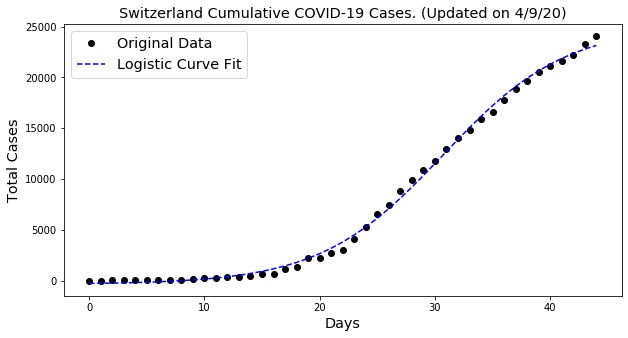



Netherlands

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 21903
	Confirmed cases on 4/2/20 	 14788
	Ratio: 1.48
	Weekly increase: 48.1 %
	Daily increase: 5.8 % per day
	Doubling Time (represents recent growth): 12.4 days

** Based on Logistic Fit**

	R^2: 0.9993287947353594
	Doubling Time (during middle of growth):  7.99 (± 0.35 ) days
	param:  [ 3.14988054e+02  1.73607568e-01 -2.27673662e+02  2.59737407e+04]

 exponential R^2  0.8944743666487499


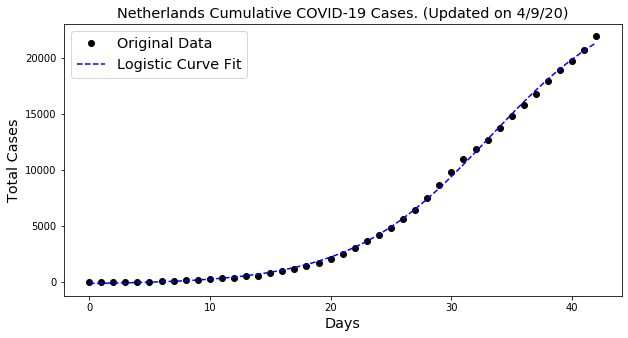



Canada

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 20654
	Confirmed cases on 4/2/20 	 11284
	Ratio: 1.83
	Weekly increase: 83.0 %
	Daily increase: 9.0 % per day
	Doubling Time (represents recent growth): 8.0 days

** Based on Logistic Fit**

	R^2: 0.9990686413655555
	Doubling Time (during middle of growth):  6.77 (± 0.25 ) days
	param:  [ 1.36115823e+06  2.04687787e-01 -2.95971362e+01  2.77341341e+04]

** Based on Exponential Fit **

	R^2: 0.9869899288230495
	Doubling Time (represents overall growth):  5.84 (± 0.33 ) days
	param:  [   3.50161393    0.11864983 -100.        ]


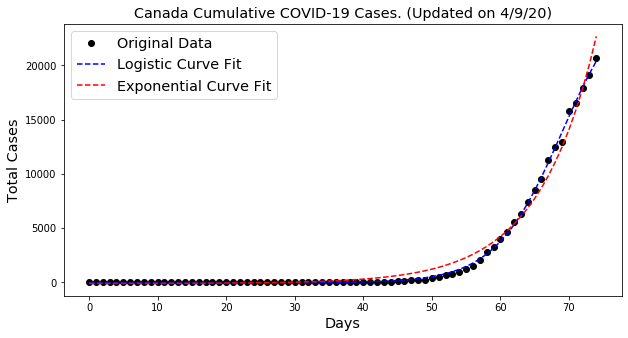



Brazil

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 18092
	Confirmed cases on 4/2/20 	 8044
	Ratio: 2.25
	Weekly increase: 124.9 %
	Daily increase: 12.3 % per day
	Doubling Time (represents recent growth): 6.0 days

** Based on Logistic Fit**

	R^2: 0.9979552256792376
	Doubling Time (during middle of growth):  8.92 (± 0.82 ) days
	param:  [ 1.50799416e+03  1.55346785e-01 -1.85481943e+02  5.19270239e+04]

** Based on Exponential Fit **

	R^2: 0.9956178138535154
	Doubling Time (represents overall growth):  5.3 (± 0.25 ) days
	param:  [  67.6550486     0.13066385 -100.        ]


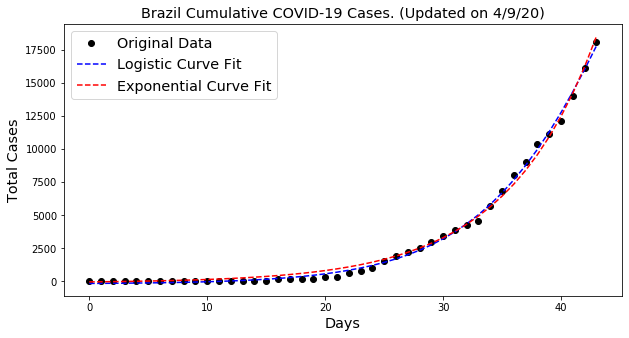



Portugal

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 13956
	Confirmed cases on 4/2/20 	 9034
	Ratio: 1.54
	Weekly increase: 54.5 %
	Daily increase: 6.4 % per day
	Doubling Time (represents recent growth): 11.2 days

** Based on Logistic Fit**

	R^2: 0.9992277533513237
	Doubling Time (during middle of growth):  6.4 (± 0.3 ) days
	param:  [ 5.98140097e+02  2.16647203e-01 -1.25920850e+02  1.57228813e+04]

 exponential R^2  0.930812472693614


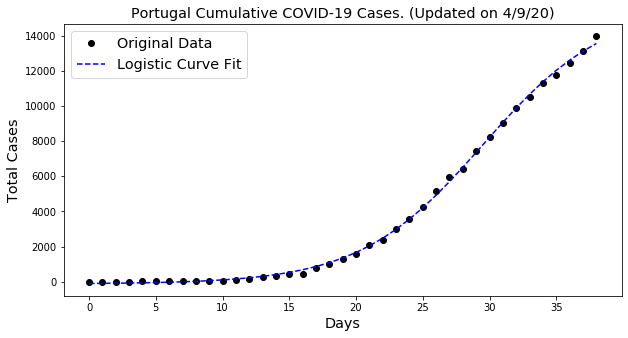



Austria

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 13244
	Confirmed cases on 4/2/20 	 11129
	Ratio: 1.19
	Weekly increase: 19.0 %
	Daily increase: 2.5 % per day
	Doubling Time (represents recent growth): 27.9 days

** Based on Logistic Fit**

	R^2: 0.9993793606230997
	Doubling Time (during middle of growth):  5.8 (± 0.2 ) days
	param:  [ 1.31374331e+03  2.39182928e-01 -5.85246740e+01  1.33465484e+04]

 exponential R^2  0.8330360592532251


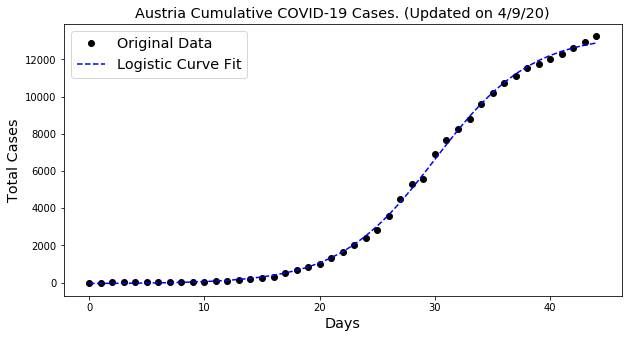



Korea, South

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 10423
	Confirmed cases on 4/2/20 	 9976
	Ratio: 1.04
	Weekly increase: 4.5 %
	Daily increase: 0.6 % per day
	Doubling Time (represents recent growth): 110.7 days

** Based on Logistic Fit**

	R^2: 0.9908207443610916
	Doubling Time (during middle of growth):  6.35 (± 0.67 ) days
	param:  [ 8.24239984e+03  2.18261339e-01 -1.35963914e+02  9.53288468e+03]

 exponential R^2  0.5750917139198527


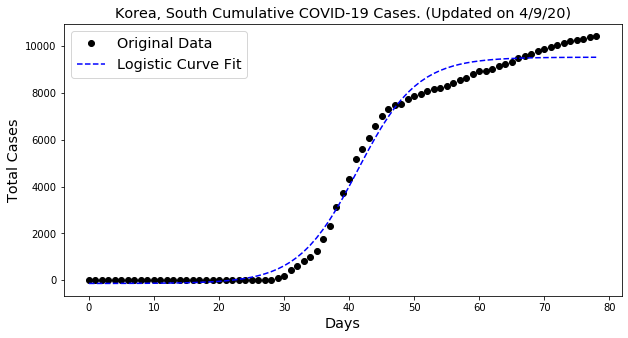



Russia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 10131
	Confirmed cases on 4/2/20 	 3548
	Ratio: 2.86
	Weekly increase: 185.5 %
	Daily increase: 16.2 % per day
	Doubling Time (represents recent growth): 4.6 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.9980256423382476
	Doubling Time (represents overall growth):  4.21 (± 0.09 ) days
	param:  [  0.12073784   0.16466022 -40.49876701]


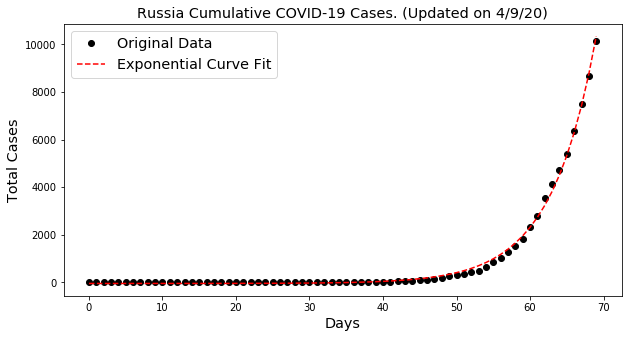



Israel

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 9968
	Confirmed cases on 4/2/20 	 6857
	Ratio: 1.45
	Weekly increase: 45.4 %
	Daily increase: 5.5 % per day
	Doubling Time (represents recent growth): 13.0 days

** Based on Logistic Fit**

	R^2: 0.9988096490552728
	Doubling Time (during middle of growth):  5.45 (± 0.26 ) days
	param:  [ 1.95145209e+04  2.54475344e-01 -9.36436292e+00  1.07238245e+04]

** Based on Exponential Fit **

	R^2: 0.9618019329563603
	Doubling Time (represents overall growth):  6.71 (± 0.95 ) days
	param:  [  82.0565829     0.10337762 -100.        ]


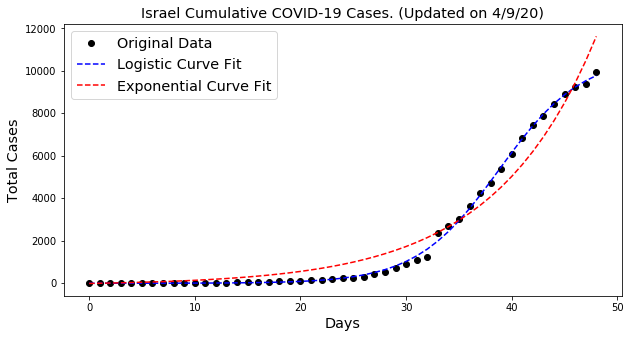



Sweden

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 9141
	Confirmed cases on 4/2/20 	 5568
	Ratio: 1.64
	Weekly increase: 64.2 %
	Daily increase: 7.3 % per day
	Doubling Time (represents recent growth): 9.8 days

** Based on Logistic Fit**

	R^2: 0.9982743984035192
	Doubling Time (during middle of growth):  12.05 (± 0.72 ) days
	param:  [ 3.11222502e+03  1.15083785e-01 -6.85221896e+01  1.89977445e+04]

** Based on Exponential Fit **

	R^2: 0.9949567495010951
	Doubling Time (represents overall growth):  8.02 (± 0.31 ) days
	param:  [ 2.47318799e+01  8.63987814e-02 -1.00000000e+02]


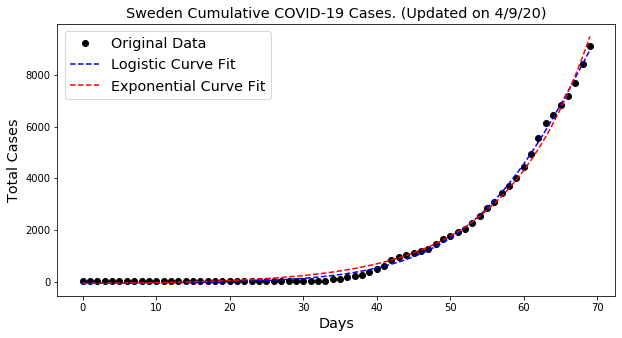



India

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 6725
	Confirmed cases on 4/2/20 	 2543
	Ratio: 2.64
	Weekly increase: 164.5 %
	Daily increase: 14.9 % per day
	Doubling Time (represents recent growth): 5.0 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.9961880719409055
	Doubling Time (represents overall growth):  4.34 (± 0.13 ) days
	param:  [ 0.09763906  0.15971505 -8.03324492]


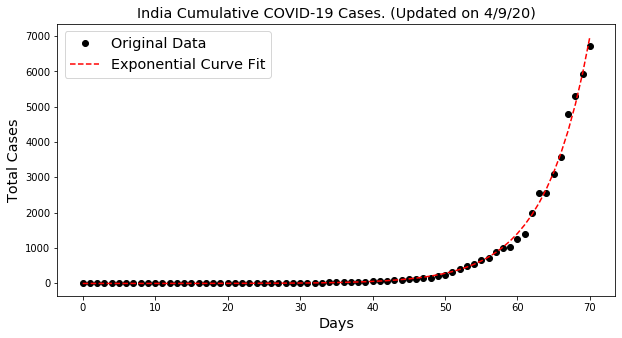



Ireland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 6574
	Confirmed cases on 4/2/20 	 3849
	Ratio: 1.71
	Weekly increase: 70.8 %
	Daily increase: 7.9 % per day
	Doubling Time (represents recent growth): 9.1 days

** Based on Logistic Fit**

	R^2: 0.9983986644768653
	Doubling Time (during middle of growth):  8.48 (± 0.64 ) days
	param:  [ 2.76972200e+02  1.63469820e-01 -1.19616880e+02  9.02161527e+03]

** Based on Exponential Fit **

	R^2: 0.9790614927945367
	Doubling Time (represents overall growth):  6.43 (± 0.76 ) days
	param:  [100.           0.10775969 -93.20263159]


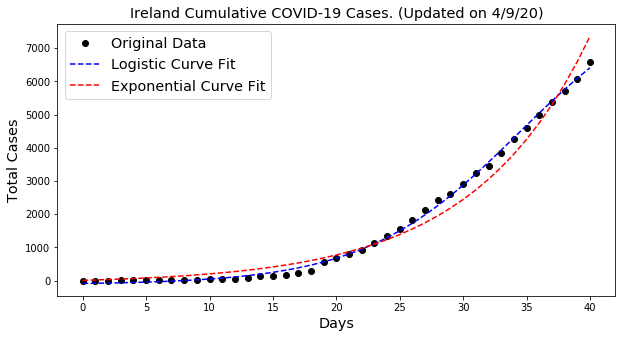



Norway

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 6211
	Confirmed cases on 4/2/20 	 5147
	Ratio: 1.21
	Weekly increase: 20.7 %
	Daily increase: 2.7 % per day
	Doubling Time (represents recent growth): 25.8 days

** Based on Logistic Fit**

	R^2: 0.9985755689030121
	Doubling Time (during middle of growth):  9.96 (± 0.67 ) days
	param:  [ 5.88981042e+01  1.39192933e-01 -2.16660884e+02  7.22400283e+03]

 exponential R^2  0.8459053254299217


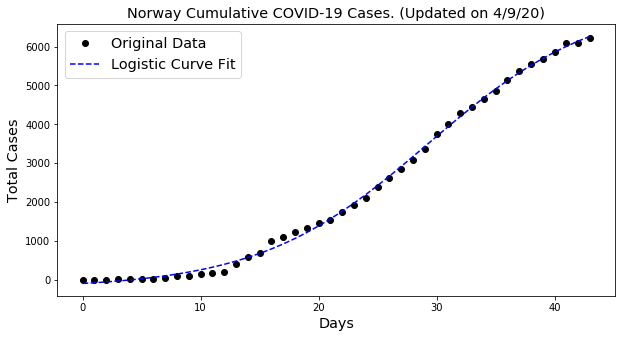



Australia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 6108
	Confirmed cases on 4/2/20 	 5116
	Ratio: 1.19
	Weekly increase: 19.4 %
	Daily increase: 2.6 % per day
	Doubling Time (represents recent growth): 27.4 days

** Based on Logistic Fit**

	R^2: 0.9997024997452929
	Doubling Time (during middle of growth):  5.41 (± 0.1 ) days
	param:  [6.03691510e+06 2.56369793e-01 1.39050719e+01 6.24484470e+03]

 exponential R^2  0.9474396505192433


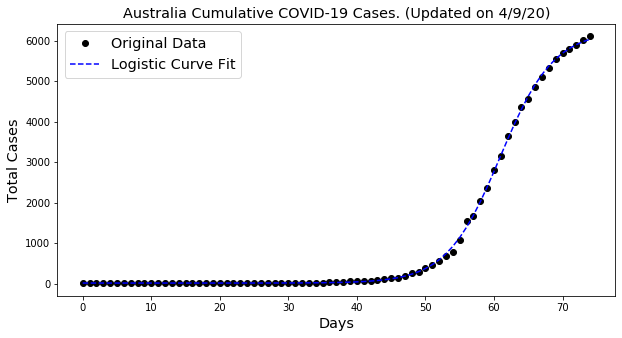



Chile

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 5972
	Confirmed cases on 4/2/20 	 3404
	Ratio: 1.75
	Weekly increase: 75.4 %
	Daily increase: 8.4 % per day
	Doubling Time (represents recent growth): 8.6 days

** Based on Logistic Fit**

	R^2: 0.9992068612413388
	Doubling Time (during middle of growth):  7.52 (± 0.41 ) days
	param:  [ 3.28110484e+02  1.84431022e-01 -8.23463306e+01  7.95111685e+03]

** Based on Exponential Fit **

	R^2: 0.9808259584459823
	Doubling Time (represents overall growth):  6.08 (± 0.72 ) days
	param:  [ 100.            0.11391727 -100.        ]


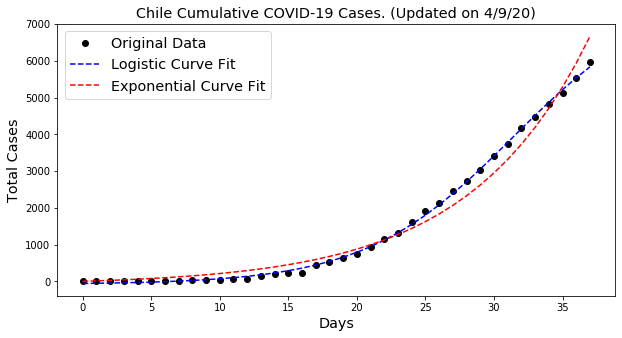



Denmark

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 5830
	Confirmed cases on 4/2/20 	 3573
	Ratio: 1.63
	Weekly increase: 63.2 %
	Daily increase: 7.2 % per day
	Doubling Time (represents recent growth): 9.9 days

** Based on Logistic Fit**

	R^2: 0.9961454247689459
	Doubling Time (during middle of growth):  21.58 (± 6.08 ) days
	param:  [ 2.45898501e+07  6.42309168e-02 -5.70220825e+02  1.08293368e+10]

** Based on Exponential Fit **

	R^2: 0.9727025690248183
	Doubling Time (represents overall growth):  6.98 (± 0.92 ) days
	param:  [1.00000000e+02 9.92882106e-02 1.00000000e+02]


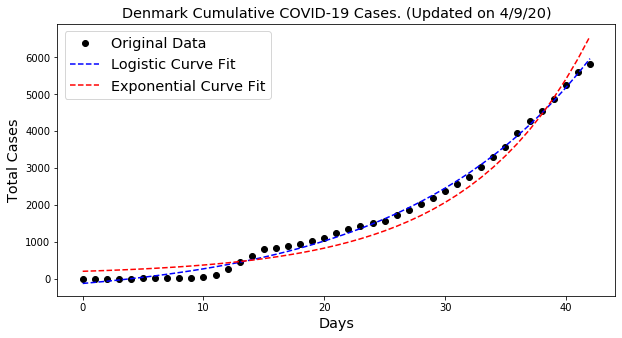



Poland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 5575
	Confirmed cases on 4/2/20 	 2946
	Ratio: 1.89
	Weekly increase: 89.2 %
	Daily increase: 9.5 % per day
	Doubling Time (represents recent growth): 7.6 days

** Based on Logistic Fit**

	R^2: 0.999579531464344
	Doubling Time (during middle of growth):  8.68 (± 0.4 ) days
	param:  [ 2.21603677e+02  1.59621806e-01 -8.56267782e+01  9.59795961e+03]

** Based on Exponential Fit **

	R^2: 0.990275257020772
	Doubling Time (represents overall growth):  6.04 (± 0.52 ) days
	param:  [100.           0.11476103 -99.99999997]


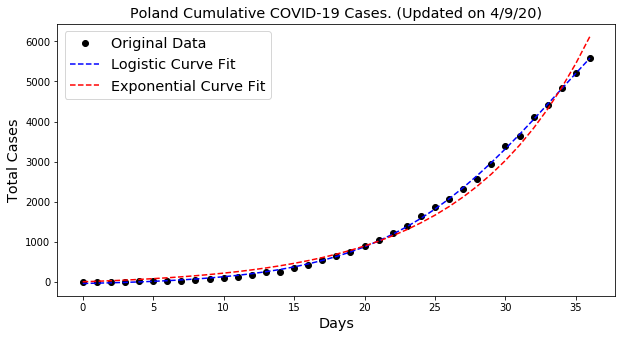



Czechia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 5569
	Confirmed cases on 4/2/20 	 3858
	Ratio: 1.44
	Weekly increase: 44.3 %
	Daily increase: 5.4 % per day
	Doubling Time (represents recent growth): 13.2 days

** Based on Logistic Fit**

	R^2: 0.9988464694610413
	Doubling Time (during middle of growth):  7.84 (± 0.47 ) days
	param:  [ 1.87464890e+02  1.76832554e-01 -9.25651095e+01  6.48637744e+03]

 exponential R^2  0.9468542119242077


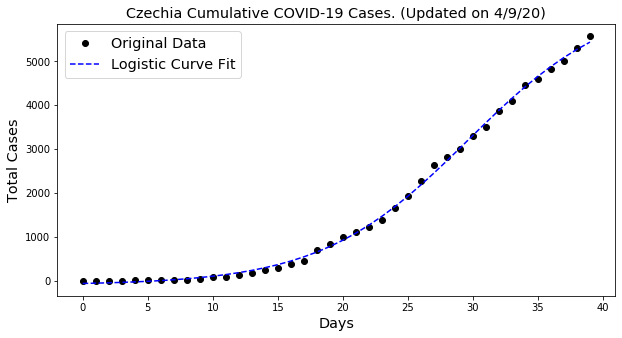



Peru

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 5256
	Confirmed cases on 4/2/20 	 1414
	Ratio: 3.72
	Weekly increase: 271.7 %
	Daily increase: 20.6 % per day
	Doubling Time (represents recent growth): 3.7 days

** Based on Logistic Fit**

	R^2: 0.985424897490244
	Doubling Time (during middle of growth):  7.28 (± 0.54 ) days
	param:  [2.76879712e+10 1.90379960e-01 8.70926861e+01 2.08801612e+11]

** Based on Exponential Fit **

	R^2: 0.9854248978863184
	Doubling Time (represents overall growth):  3.64 (± 0.34 ) days
	param:  [ 7.54132566  0.19037961 87.09166701]


/home/ma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning:

invalid value encountered in sqrt



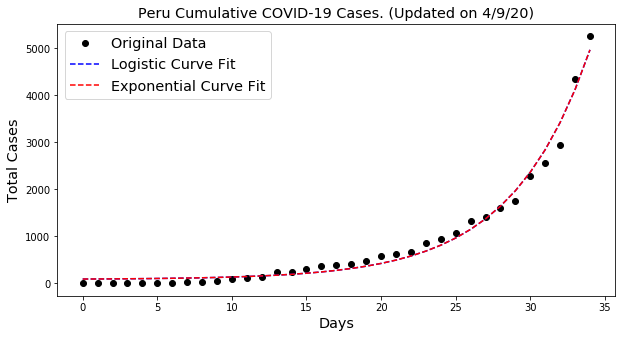



Romania

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 5202
	Confirmed cases on 4/2/20 	 2738
	Ratio: 1.9
	Weekly increase: 90.0 %
	Daily increase: 9.6 % per day
	Doubling Time (represents recent growth): 7.6 days

** Based on Logistic Fit**

	R^2: 0.9986836427656574
	Doubling Time (during middle of growth):  7.3 (± 0.45 ) days
	param:  [ 1.35696675e+03  1.89960337e-01 -2.52470178e+01  7.03479395e+03]

** Based on Exponential Fit **

	R^2: 0.9873802880614977
	Doubling Time (represents overall growth):  6.38 (± 0.55 ) days
	param:  [  53.48706954    0.1085717  -100.        ]


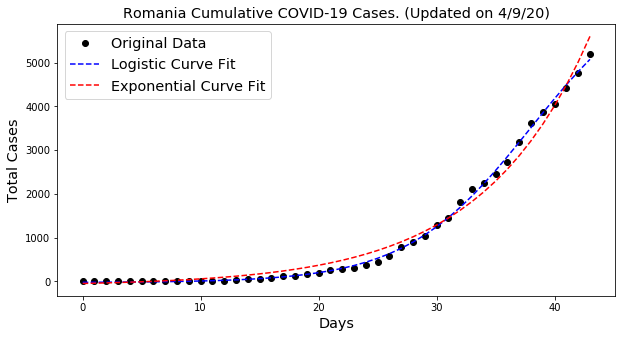



Ecuador

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 4965
	Confirmed cases on 4/2/20 	 3163
	Ratio: 1.57
	Weekly increase: 57.0 %
	Daily increase: 6.7 % per day
	Doubling Time (represents recent growth): 10.8 days

** Based on Logistic Fit**

	R^2: 0.9903963864068832
	Doubling Time (during middle of growth):  7.82 (± 1.4 ) days
	param:  [ 2.76291457e+02  1.77259246e-01 -1.01834954e+02  5.85892249e+03]

** Based on Exponential Fit **

	R^2: 0.9683633359272379
	Doubling Time (represents overall growth):  6.77 (± 1.05 ) days
	param:  [ 100.            0.10231204 -100.        ]


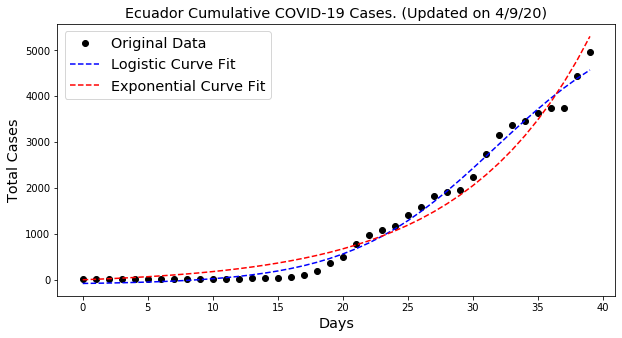



Japan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 4667
	Confirmed cases on 4/2/20 	 2495
	Ratio: 1.87
	Weekly increase: 87.1 %
	Daily increase: 9.4 % per day
	Doubling Time (represents recent growth): 7.7 days

** Based on Logistic Fit**

	R^2: 0.9931331667697152
	Doubling Time (during middle of growth):  17.42 (± 0.49 ) days
	param:  [1.90366604e+10 7.95631494e-02 2.95776989e+01 1.71112209e+11]

** Based on Exponential Fit **

	R^2: 0.9931331670384103
	Doubling Time (represents overall growth):  8.71 (± 0.36 ) days
	param:  [ 8.98861204  0.07956308 29.5772475 ]


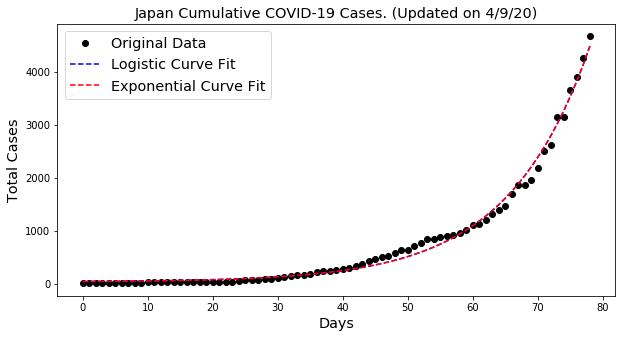



Pakistan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 4489
	Confirmed cases on 4/2/20 	 2421
	Ratio: 1.85
	Weekly increase: 85.4 %
	Daily increase: 9.2 % per day
	Doubling Time (represents recent growth): 7.9 days

** Based on Logistic Fit**

	R^2: 0.9953420907791566
	Doubling Time (during middle of growth):  11.04 (± 1.68 ) days
	param:  [ 3.09575183e+02  1.25541683e-01 -1.13162199e+02  1.11222252e+04]

** Based on Exponential Fit **

	R^2: 0.9917839220603524
	Doubling Time (represents overall growth):  6.93 (± 0.49 ) days
	param:  [  66.50883299    0.10000258 -100.        ]


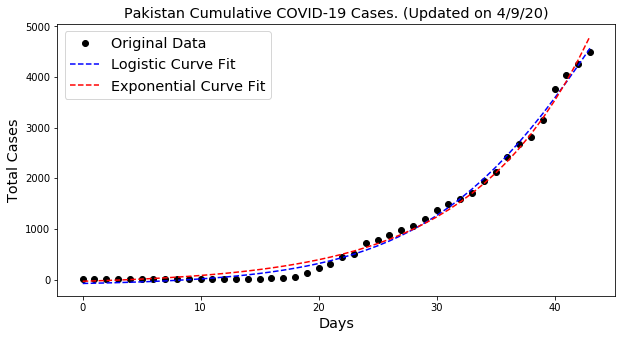



Malaysia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 4228
	Confirmed cases on 4/2/20 	 3116
	Ratio: 1.36
	Weekly increase: 35.7 %
	Daily increase: 4.5 % per day
	Doubling Time (represents recent growth): 15.9 days

** Based on Logistic Fit**

	R^2: 0.9977935803268698
	Doubling Time (during middle of growth):  8.56 (± 0.45 ) days
	param:  [ 2.85285700e+04  1.61918948e-01 -1.07609682e+01  4.74745940e+03]

** Based on Exponential Fit **

	R^2: 0.9742855369430894
	Doubling Time (represents overall growth):  9.55 (± 0.83 ) days
	param:  [ 2.12300053e+01  7.26185377e-02 -1.00000000e+02]


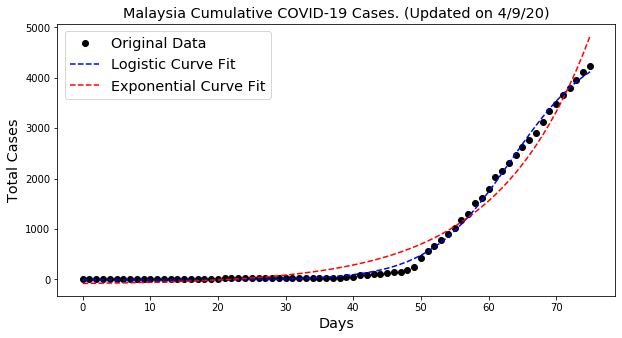



Philippines

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 4076
	Confirmed cases on 4/2/20 	 2633
	Ratio: 1.55
	Weekly increase: 54.8 %
	Daily increase: 6.4 % per day
	Doubling Time (represents recent growth): 11.1 days

** Based on Logistic Fit**

	R^2: 0.9979296903524341
	Doubling Time (during middle of growth):  5.24 (± 0.28 ) days
	param:  [1.34023583e+07 2.64562211e-01 1.52729435e+01 4.54858613e+03]

** Based on Exponential Fit **

	R^2: 0.9728394630182705
	Doubling Time (represents overall growth):  6.42 (± 0.54 ) days
	param:  [  2.48252749   0.10802746 -76.13779982]


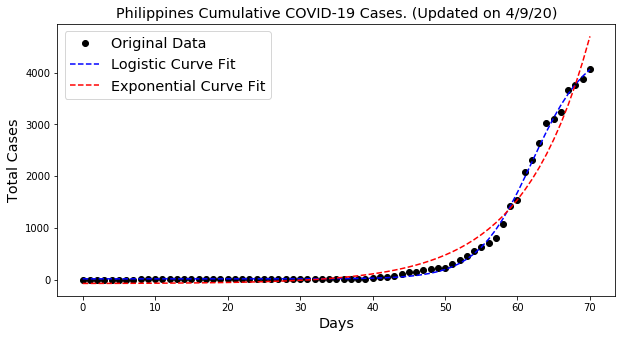



Indonesia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 3293
	Confirmed cases on 4/2/20 	 1790
	Ratio: 1.84
	Weekly increase: 84.0 %
	Daily increase: 9.1 % per day
	Doubling Time (represents recent growth): 8.0 days

** Based on Logistic Fit**

	R^2: 0.9974662799221635
	Doubling Time (during middle of growth):  11.3 (± 1.49 ) days
	param:  [ 1.11324512e+02  1.22700176e-01 -1.21444750e+02  6.63309551e+03]

** Based on Exponential Fit **

	R^2: 0.9917176122581322
	Doubling Time (represents overall growth):  7.42 (± 0.63 ) days
	param:  [ 1.00000000e+02  9.34066265e-02 -1.00000000e+02]


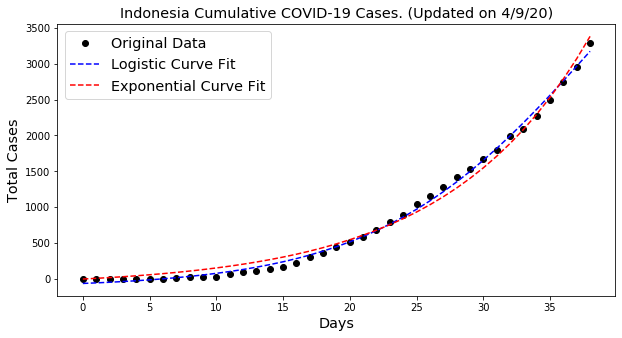



Saudi Arabia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 3287
	Confirmed cases on 4/2/20 	 1885
	Ratio: 1.74
	Weekly increase: 74.4 %
	Daily increase: 8.3 % per day
	Doubling Time (represents recent growth): 8.7 days

** Based on Logistic Fit**

	R^2: 0.9967997993759694
	Doubling Time (during middle of growth):  10.02 (± 1.3 ) days
	param:  [ 1.17903495e+02  1.38296978e-01 -1.02220524e+02  5.16469165e+03]

** Based on Exponential Fit **

	R^2: 0.986807816037202
	Doubling Time (represents overall growth):  7.37 (± 0.78 ) days
	param:  [ 1.00000000e+02  9.40354976e-02 -1.00000000e+02]


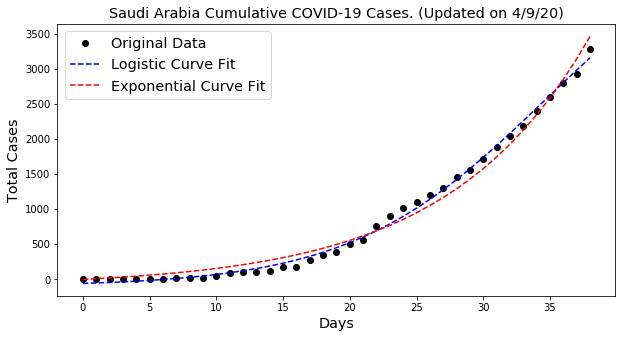



Mexico

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 3181
	Confirmed cases on 4/2/20 	 1378
	Ratio: 2.31
	Weekly increase: 130.8 %
	Daily increase: 12.7 % per day
	Doubling Time (represents recent growth): 5.8 days

** Based on Logistic Fit**

	R^2: 0.9978648477617387
	Doubling Time (during middle of growth):  9.78 (± 1.03 ) days
	param:  [ 1.02006217e+03  1.41765823e-01 -4.58815751e+01  1.27323740e+04]

** Based on Exponential Fit **

	R^2: 0.9973712069477655
	Doubling Time (represents overall growth):  5.72 (± 0.22 ) days
	param:  [ 22.53337864   0.12121166 -73.60055426]


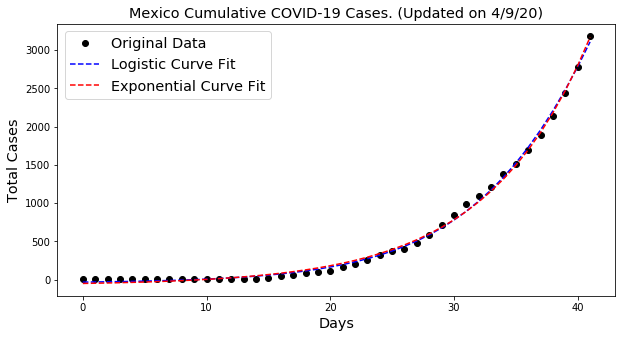



Luxembourg

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 3115
	Confirmed cases on 4/2/20 	 2487
	Ratio: 1.25
	Weekly increase: 25.3 %
	Daily increase: 3.3 % per day
	Doubling Time (represents recent growth): 21.6 days

** Based on Logistic Fit**

	R^2: 0.9971288927845512
	Doubling Time (during middle of growth):  6.06 (± 0.49 ) days
	param:  [ 4.72085393e+02  2.28743925e-01 -5.76254236e+01  3.17406497e+03]

 exponential R^2  0.9204949076549057


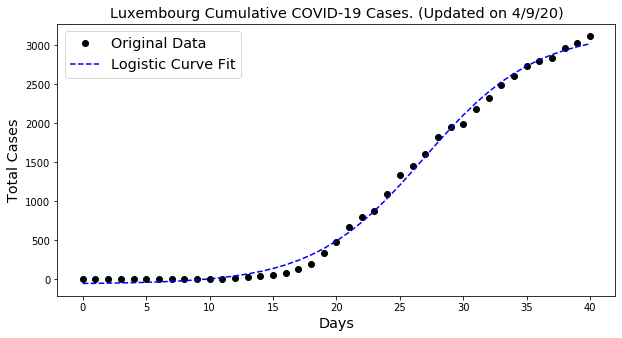



United Arab Emirates

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 2990
	Confirmed cases on 4/2/20 	 1024
	Ratio: 2.92
	Weekly increase: 192.0 %
	Daily increase: 16.5 % per day
	Doubling Time (represents recent growth): 4.5 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.9968726883457454
	Doubling Time (represents overall growth):  4.46 (± 0.12 ) days
	param:  [0.04986023 0.15550917 9.52748546]


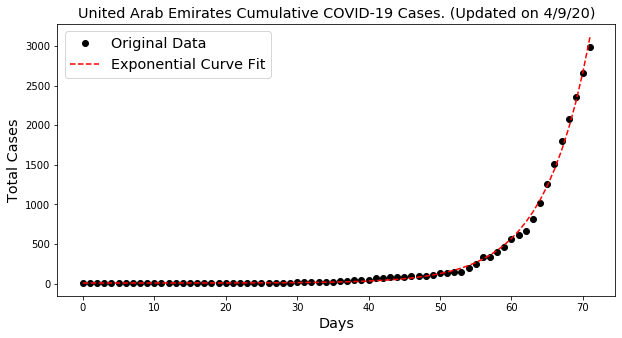



Serbia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 2867
	Confirmed cases on 4/2/20 	 1171
	Ratio: 2.45
	Weekly increase: 144.8 %
	Daily increase: 13.6 % per day
	Doubling Time (represents recent growth): 5.4 days

** Based on Logistic Fit**

	R^2: 0.9984254092370272
	Doubling Time (during middle of growth):  7.62 (± 0.69 ) days
	param:  [ 4.96019791e+02  1.82033026e-01 -1.18104224e+01  5.91032574e+03]

** Based on Exponential Fit **

	R^2: 0.995668993300598
	Doubling Time (represents overall growth):  5.62 (± 0.33 ) days
	param:  [ 47.43683397   0.12329708 -97.44992649]


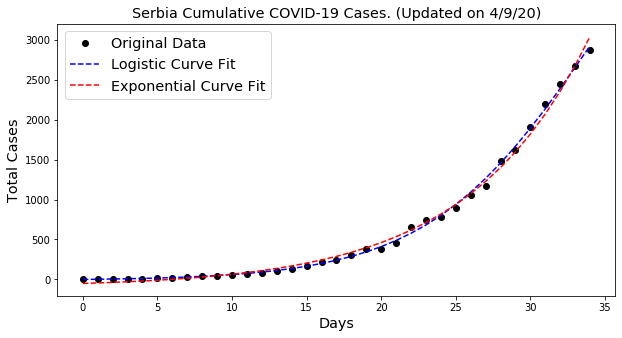



Finland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 2605
	Confirmed cases on 4/2/20 	 1518
	Ratio: 1.72
	Weekly increase: 71.6 %
	Daily increase: 8.0 % per day
	Doubling Time (represents recent growth): 9.0 days

** Based on Logistic Fit**

	R^2: 0.9950969186984675
	Doubling Time (during middle of growth):  10.84 (± 0.99 ) days
	param:  [ 4.96327912e+03  1.27847426e-01 -2.41216729e+01  3.98012924e+03]

** Based on Exponential Fit **

	R^2: 0.9885530442658582
	Doubling Time (represents overall growth):  8.65 (± 0.5 ) days
	param:  [  9.54626423   0.08013939 -71.90384933]


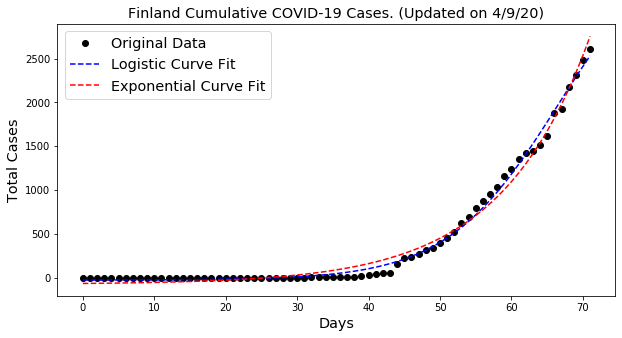



Panama

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 2528
	Confirmed cases on 4/2/20 	 1317
	Ratio: 1.92
	Weekly increase: 92.0 %
	Daily increase: 9.8 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.9974711034390107
	Doubling Time (during middle of growth):  9.09 (± 1.33 ) days
	param:  [ 6.21318158e+01  1.52528591e-01 -9.79417892e+01  4.08060157e+03]

** Based on Exponential Fit **

	R^2: 0.983301409905518
	Doubling Time (represents overall growth):  6.25 (± 0.88 ) days
	param:  [100.           0.11084616 -65.24660972]


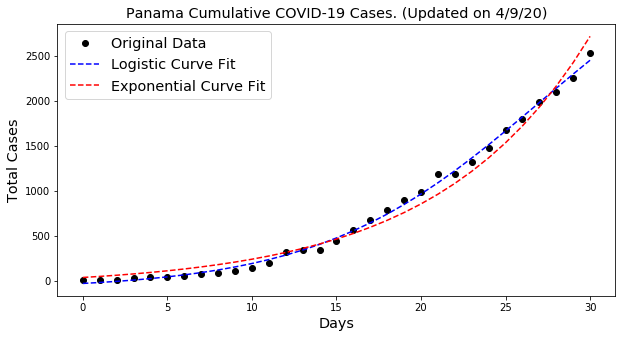



Thailand

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 2423
	Confirmed cases on 4/2/20 	 1875
	Ratio: 1.29
	Weekly increase: 29.2 %
	Daily increase: 3.7 % per day
	Doubling Time (represents recent growth): 18.9 days

** Based on Logistic Fit**

	R^2: 0.9985499882321721
	Doubling Time (during middle of growth):  6.26 (± 0.26 ) days
	param:  [2.25813573e+06 2.21476419e-01 2.13167780e+01 2.53311225e+03]

** Based on Exponential Fit **

	R^2: 0.9624738348299082
	Doubling Time (represents overall growth):  8.75 (± 0.86 ) days
	param:  [  6.00945956   0.07921404 -55.10533459]


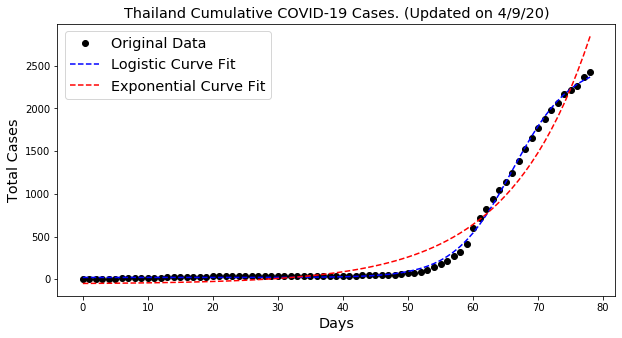



Qatar

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 2376
	Confirmed cases on 4/2/20 	 949
	Ratio: 2.5
	Weekly increase: 150.4 %
	Daily increase: 14.0 % per day
	Doubling Time (represents recent growth): 5.3 days

** Based on Logistic Fit**

	R^2: 0.9597642893301227
	Doubling Time (during middle of growth):  12.1 (± nan ) days
	param:  [1.01343329e+09 1.14534663e-01 8.31911864e+01 2.39675210e+10]

** Based on Exponential Fit **

	R^2: 0.9597642907629307
	Doubling Time (represents overall growth):  6.05 (± 0.96 ) days
	param:  [23.65047986  0.11453395 83.18869005]


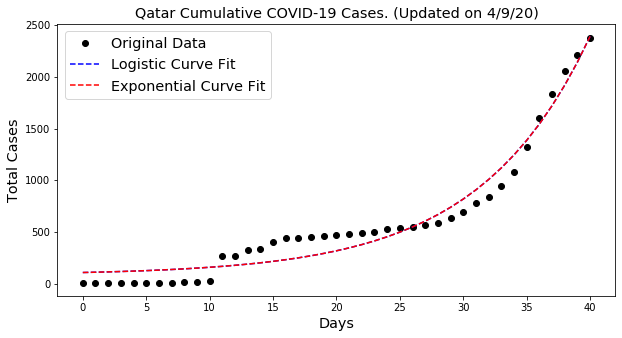



Dominican Republic

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 2349
	Confirmed cases on 4/2/20 	 1380
	Ratio: 1.7
	Weekly increase: 70.2 %
	Daily increase: 7.9 % per day
	Doubling Time (represents recent growth): 9.1 days

** Based on Logistic Fit**

	R^2: 0.995626753448311
	Doubling Time (during middle of growth):  6.46 (± 0.72 ) days
	param:  [ 9.43772922e+02  2.14677556e-01 -2.95037756e+01  2.69601217e+03]

** Based on Exponential Fit **

	R^2: 0.9783351846258177
	Doubling Time (represents overall growth):  6.76 (± 0.86 ) days
	param:  [  47.77310522    0.10258238 -100.        ]


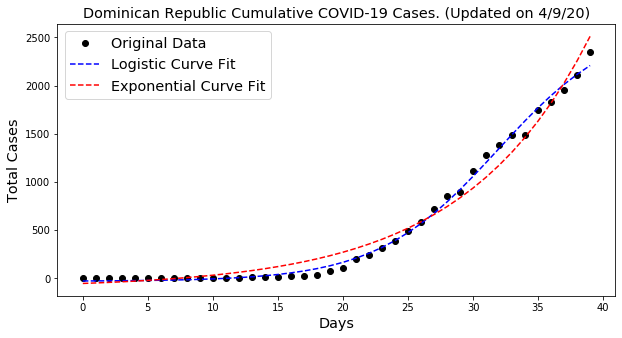



Colombia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 2223
	Confirmed cases on 4/2/20 	 1161
	Ratio: 1.91
	Weekly increase: 91.5 %
	Daily increase: 9.7 % per day
	Doubling Time (represents recent growth): 7.5 days

** Based on Logistic Fit**

	R^2: 0.9968587538177147
	Doubling Time (during middle of growth):  10.15 (± 1.59 ) days
	param:  [ 1.22963461e+02  1.36633578e-01 -7.75935128e+01  4.82298830e+03]

** Based on Exponential Fit **

	R^2: 0.99380662947128
	Doubling Time (represents overall growth):  6.83 (± 0.53 ) days
	param:  [  75.45160691    0.10151355 -100.        ]


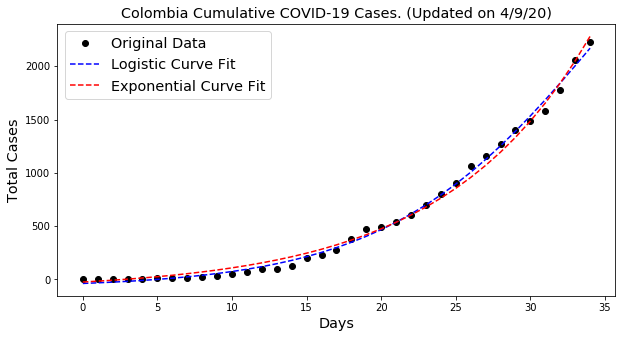



Greece

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 1955
	Confirmed cases on 4/2/20 	 1544
	Ratio: 1.27
	Weekly increase: 26.6 %
	Daily increase: 3.4 % per day
	Doubling Time (represents recent growth): 20.6 days

** Based on Logistic Fit**

	R^2: 0.9983919625271359
	Doubling Time (during middle of growth):  10.07 (± 0.74 ) days
	param:  [ 8.49244994e+01  1.37684060e-01 -4.77329598e+01  2.41358654e+03]

** Based on Exponential Fit **

	R^2: 0.9684910633159288
	Doubling Time (represents overall growth):  9.43 (± 1.57 ) days
	param:  [ 1.00000000e+02  7.35433621e-02 -7.26419814e+01]


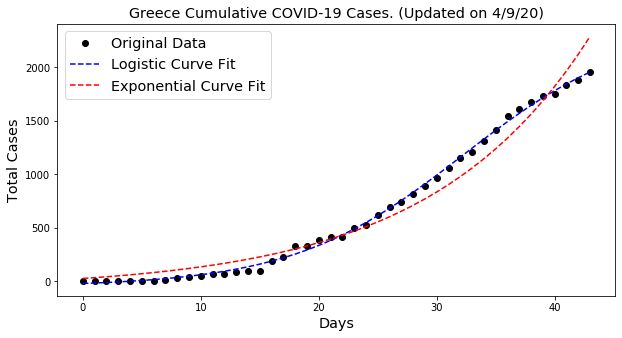



South Africa

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 1934
	Confirmed cases on 4/2/20 	 1462
	Ratio: 1.32
	Weekly increase: 32.3 %
	Daily increase: 4.1 % per day
	Doubling Time (represents recent growth): 17.3 days

** Based on Logistic Fit**

	R^2: 0.990145551134455
	Doubling Time (during middle of growth):  4.62 (± 0.72 ) days
	param:  [ 5.88922210e+02  2.99813785e-01 -1.76153527e+01  1.77726533e+03]

 exponential R^2  0.8968981151607845


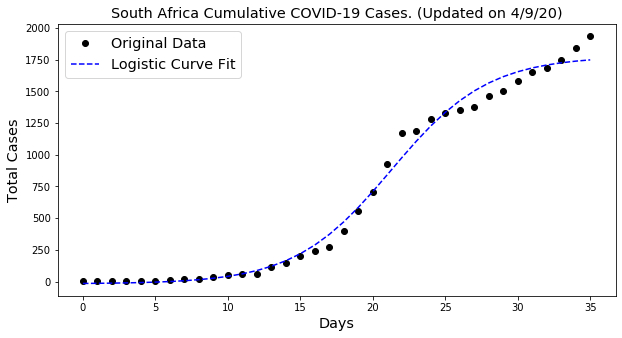



Singapore

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 1910
	Confirmed cases on 4/2/20 	 1049
	Ratio: 1.82
	Weekly increase: 82.1 %
	Daily increase: 8.9 % per day
	Doubling Time (represents recent growth): 8.1 days

** Based on Logistic Fit**

	R^2: 0.9949071839251891
	Doubling Time (during middle of growth):  16.59 (± 1.89 ) days
	param:  [3.80984136e+03 8.35568146e-02 2.05461907e+01 1.25618080e+04]

** Based on Exponential Fit **

	R^2: 0.9947896184879401
	Doubling Time (represents overall growth):  9.0 (± 0.33 ) days
	param:  [ 4.74345046  0.07704375 14.27411909]


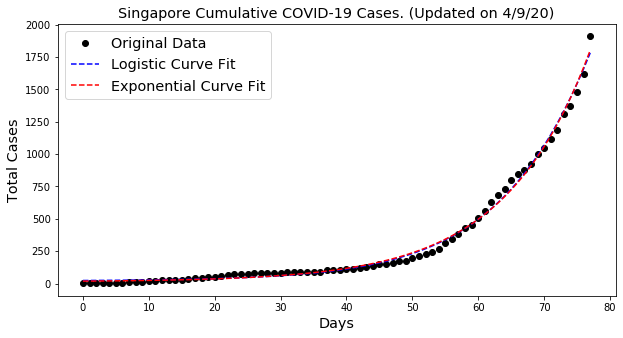



Ukraine

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 1892
	Confirmed cases on 4/2/20 	 897
	Ratio: 2.11
	Weekly increase: 110.9 %
	Daily increase: 11.3 % per day
	Doubling Time (represents recent growth): 6.5 days

** Based on Logistic Fit**

	R^2: 0.9953361979774089
	Doubling Time (during middle of growth):  5.65 (± 0.67 ) days
	param:  [ 2.36722162e+03  2.45389422e-01 -1.43215775e+01  2.25858844e+03]

** Based on Exponential Fit **

	R^2: 0.9823118661294488
	Doubling Time (represents overall growth):  5.83 (± 0.64 ) days
	param:  [ 25.32157457   0.11892894 -92.078309  ]


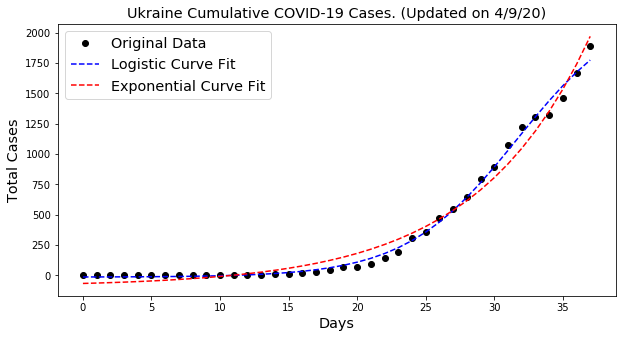



Argentina

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 1795
	Confirmed cases on 4/2/20 	 1133
	Ratio: 1.58
	Weekly increase: 58.4 %
	Daily increase: 6.8 % per day
	Doubling Time (represents recent growth): 10.5 days

** Based on Logistic Fit**

	R^2: 0.9978429945220877
	Doubling Time (during middle of growth):  6.7 (± 0.54 ) days
	param:  [ 3.71815335e+02  2.06901515e-01 -1.47694223e+01  2.08394925e+03]

** Based on Exponential Fit **

	R^2: 0.9759155159282982
	Doubling Time (represents overall growth):  7.73 (± 1.19 ) days
	param:  [ 7.66889819e+01  8.97256313e-02 -1.00000000e+02]


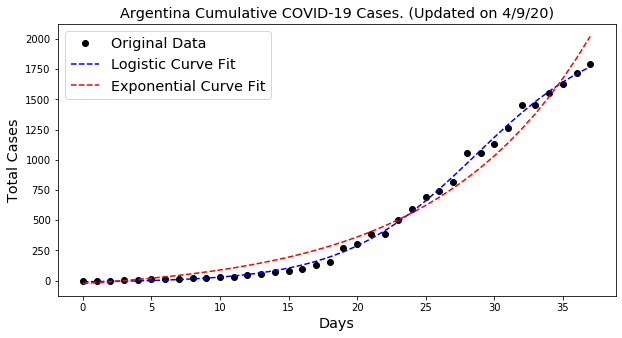



Egypt

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 1699
	Confirmed cases on 4/2/20 	 865
	Ratio: 1.96
	Weekly increase: 96.4 %
	Daily increase: 10.1 % per day
	Doubling Time (represents recent growth): 7.2 days

** Based on Logistic Fit**

	R^2: 0.9975048699932679
	Doubling Time (during middle of growth):  14.51 (± 1.56 ) days
	param:  [ 1.75965867e+03  9.55659040e-02 -3.23457282e+01  1.76081544e+04]

** Based on Exponential Fit **

	R^2: 0.997438399476942
	Doubling Time (represents overall growth):  7.69 (± 0.25 ) days
	param:  [ 12.34737981   0.09009096 -38.30067944]


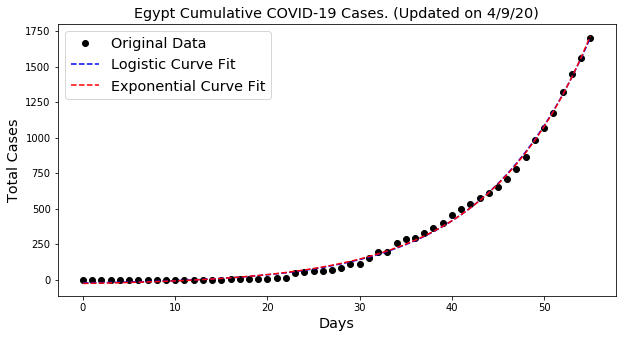



Algeria

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 1666
	Confirmed cases on 4/2/20 	 986
	Ratio: 1.69
	Weekly increase: 69.0 %
	Daily increase: 7.8 % per day
	Doubling Time (represents recent growth): 9.3 days

** Based on Logistic Fit**

	R^2: 0.9975939234286255
	Doubling Time (during middle of growth):  6.3 (± 0.48 ) days
	param:  [3.85686369e+03 2.19988732e-01 8.25399888e+00 2.06677963e+03]

** Based on Exponential Fit **

	R^2: 0.9823158172632799
	Doubling Time (represents overall growth):  6.88 (± 0.69 ) days
	param:  [ 22.785881     0.10074873 -72.5897245 ]


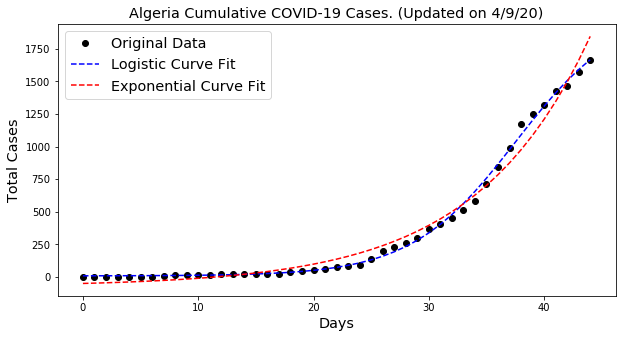



Iceland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 1648
	Confirmed cases on 4/2/20 	 1319
	Ratio: 1.25
	Weekly increase: 24.9 %
	Daily increase: 3.2 % per day
	Doubling Time (represents recent growth): 21.8 days

** Based on Logistic Fit**

	R^2: 0.9988678612517272
	Doubling Time (during middle of growth):  8.37 (± 0.48 ) days
	param:  [ 1.14411471e+02  1.65546588e-01 -2.15640290e+01  1.86197611e+03]

** Based on Exponential Fit **

	R^2: 0.9594088021745413
	Doubling Time (represents overall growth):  9.41 (± 1.89 ) days
	param:  [ 1.00000000e+02  7.36742350e-02 -7.24560557e+01]


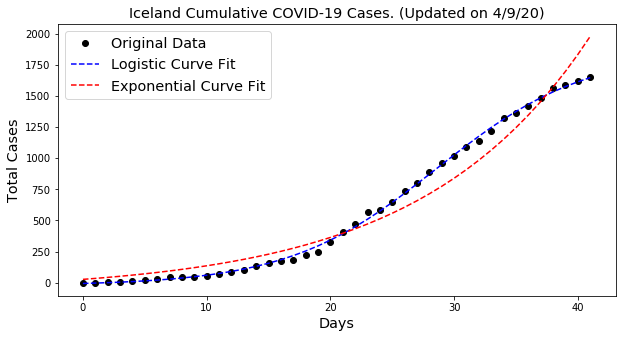



Belarus

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 1486
	Confirmed cases on 4/2/20 	 304
	Ratio: 4.89
	Weekly increase: 388.8 %
	Daily increase: 25.4 % per day
	Doubling Time (represents recent growth): 3.1 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.9937430676757766
	Doubling Time (represents overall growth):  2.79 (± 0.14 ) days
	param:  [ 0.05365008  0.24828338 23.04231548]


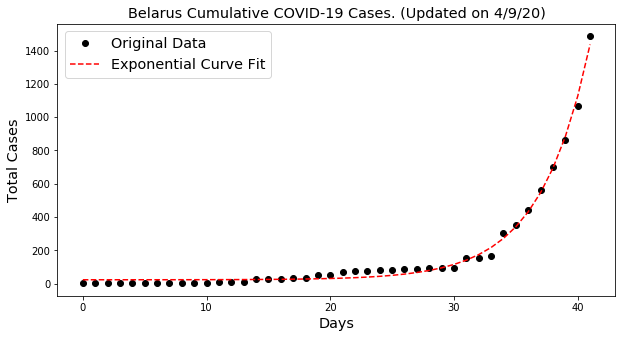



Croatia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 1407
	Confirmed cases on 4/2/20 	 1011
	Ratio: 1.39
	Weekly increase: 39.2 %
	Daily increase: 4.8 % per day
	Doubling Time (represents recent growth): 14.7 days

** Based on Logistic Fit**

	R^2: 0.9984757770500344
	Doubling Time (during middle of growth):  6.42 (± 0.37 ) days
	param:  [ 1.32768428e+03  2.15879179e-01 -6.34150880e+00  1.48937046e+03]

** Based on Exponential Fit **

	R^2: 0.9694973206761547
	Doubling Time (represents overall growth):  8.9 (± 1.37 ) days
	param:  [ 5.48506102e+01  7.78936374e-02 -1.00000000e+02]


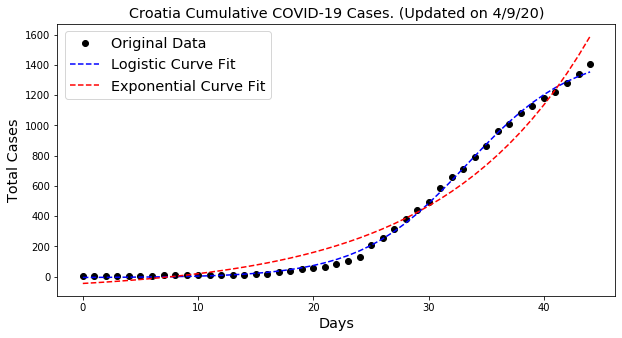



Morocco

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 1374
	Confirmed cases on 4/2/20 	 708
	Ratio: 1.94
	Weekly increase: 94.1 %
	Daily increase: 9.9 % per day
	Doubling Time (represents recent growth): 7.3 days

** Based on Logistic Fit**

	R^2: 0.9981022582606837
	Doubling Time (during middle of growth):  7.42 (± 0.61 ) days
	param:  [ 5.03796361e+02  1.86710201e-01 -1.50742758e+01  1.92842141e+03]

** Based on Exponential Fit **

	R^2: 0.9897354949662273
	Doubling Time (represents overall growth):  7.05 (± 0.63 ) days
	param:  [ 37.06798565   0.09829083 -87.79676736]


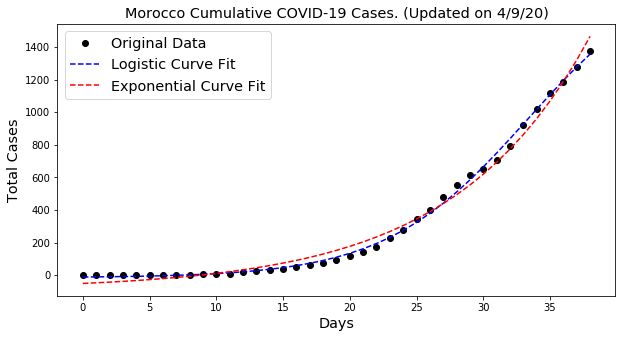



Moldova

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 1289
	Confirmed cases on 4/2/20 	 505
	Ratio: 2.55
	Weekly increase: 155.2 %
	Daily increase: 14.3 % per day
	Doubling Time (represents recent growth): 5.2 days

** Based on Logistic Fit**

	R^2: 0.9977007147508273
	Doubling Time (during middle of growth):  6.79 (± 0.74 ) days
	param:  [5.93341610e+02 2.04195061e-01 5.70388759e+00 2.42310058e+03]

** Based on Exponential Fit **

	R^2: 0.9944398728212455
	Doubling Time (represents overall growth):  5.26 (± 0.36 ) days
	param:  [ 20.53261477   0.13186778 -36.71966862]


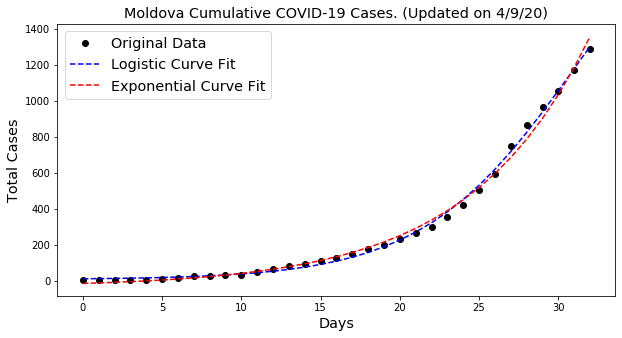



New Zealand

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 1239
	Confirmed cases on 4/2/20 	 797
	Ratio: 1.55
	Weekly increase: 55.5 %
	Daily increase: 6.5 % per day
	Doubling Time (represents recent growth): 11.0 days

** Based on Logistic Fit**

	R^2: 0.9979006979033455
	Doubling Time (during middle of growth):  5.46 (± 0.38 ) days
	param:  [ 3.69081547e+03  2.53689029e-01 -8.18051498e+00  1.36752691e+03]

** Based on Exponential Fit **

	R^2: 0.9699488282341263
	Doubling Time (represents overall growth):  7.54 (± 1.12 ) days
	param:  [ 3.50009377e+01  9.19639091e-02 -1.00000000e+02]


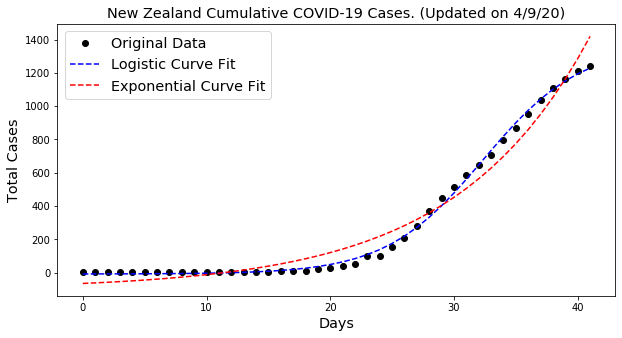



Iraq

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 1232
	Confirmed cases on 4/2/20 	 772
	Ratio: 1.6
	Weekly increase: 59.6 %
	Daily increase: 6.9 % per day
	Doubling Time (represents recent growth): 10.4 days

** Based on Logistic Fit**

	R^2: 0.9984950738659883
	Doubling Time (during middle of growth):  10.61 (± 0.8 ) days
	param:  [2.40173160e+02 1.30706721e-01 1.57337496e+00 2.07370299e+03]

** Based on Exponential Fit **

	R^2: 0.9945497791942529
	Doubling Time (represents overall growth):  9.0 (± 0.56 ) days
	param:  [ 42.98534564   0.0769919  -62.82615817]


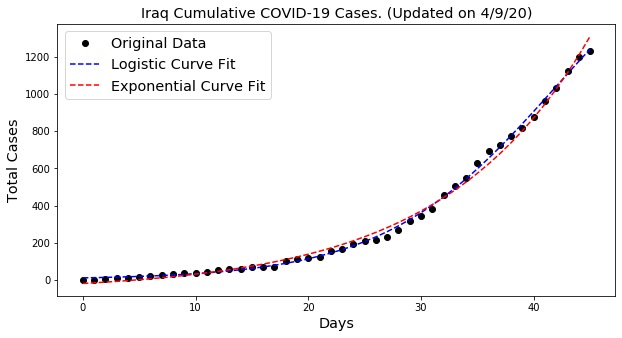



Estonia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 1207
	Confirmed cases on 4/2/20 	 858
	Ratio: 1.41
	Weekly increase: 40.7 %
	Daily increase: 5.0 % per day
	Doubling Time (represents recent growth): 14.2 days

** Based on Logistic Fit**

	R^2: 0.9940723989678579
	Doubling Time (during middle of growth):  10.61 (± 1.64 ) days
	param:  [ 8.06841864e+01  1.30674821e-01 -4.27609336e+01  1.66247383e+03]

** Based on Exponential Fit **

	R^2: 0.9803521608986245
	Doubling Time (represents overall growth):  10.32 (± 1.49 ) days
	param:  [ 8.76378934e+01  6.71390882e-02 -1.00000000e+02]


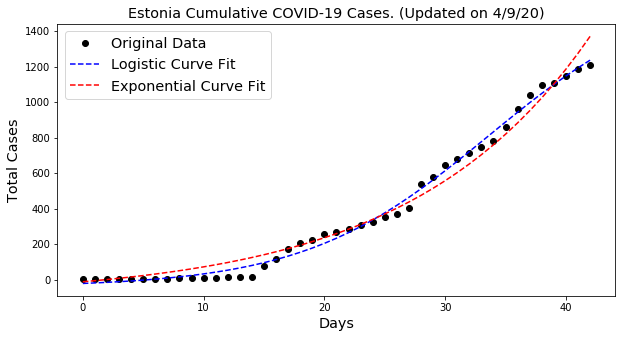



Slovenia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 1124
	Confirmed cases on 4/2/20 	 897
	Ratio: 1.25
	Weekly increase: 25.3 %
	Daily increase: 3.3 % per day
	Doubling Time (represents recent growth): 21.5 days

** Based on Logistic Fit**

	R^2: 0.9975683040139742
	Doubling Time (during middle of growth):  13.09 (± 2.09 ) days
	param:  [ 1.11639535e+01  1.05944865e-01 -1.52513889e+02  1.47741911e+03]

 exponential R^2  0.9365749792158655


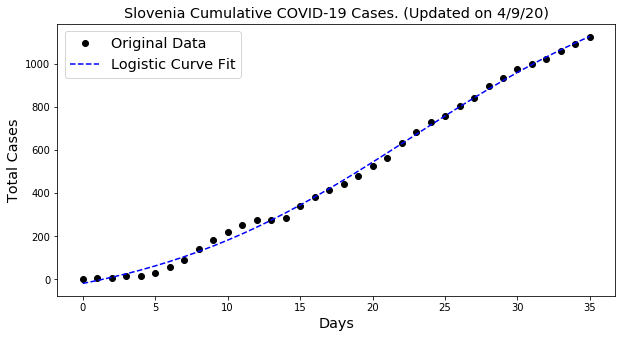



Hungary

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 980
	Confirmed cases on 4/2/20 	 585
	Ratio: 1.68
	Weekly increase: 67.5 %
	Daily increase: 7.6 % per day
	Doubling Time (represents recent growth): 9.4 days

** Based on Logistic Fit**

	R^2: 0.9974256165022243
	Doubling Time (during middle of growth):  8.47 (± 0.9 ) days
	param:  [ 1.38093818e+02  1.63612940e-01 -1.80860657e+01  1.29710802e+03]

** Based on Exponential Fit **

	R^2: 0.9902626859873623
	Doubling Time (represents overall growth):  8.78 (± 0.93 ) days
	param:  [ 6.46115470e+01  7.89602699e-02 -1.00000000e+02]


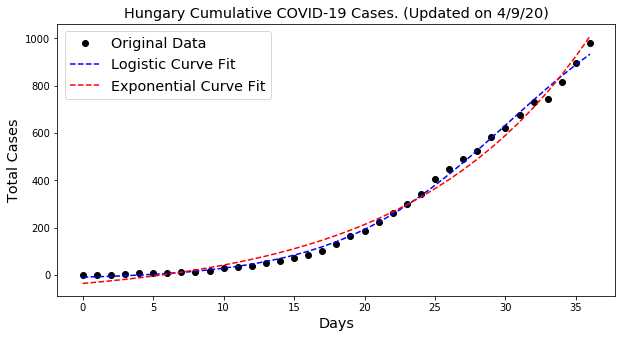



Lithuania

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 955
	Confirmed cases on 4/2/20 	 649
	Ratio: 1.47
	Weekly increase: 47.1 %
	Daily increase: 5.7 % per day
	Doubling Time (represents recent growth): 12.6 days

** Based on Logistic Fit**

	R^2: 0.9973126308239292
	Doubling Time (during middle of growth):  6.39 (± 0.52 ) days
	param:  [ 9.22163274e+02  2.17093223e-01 -1.22367876e+01  1.05381127e+03]

** Based on Exponential Fit **

	R^2: 0.972709117775735
	Doubling Time (represents overall growth):  8.84 (± 1.37 ) days
	param:  [ 4.70553053e+01  7.84476906e-02 -1.00000000e+02]


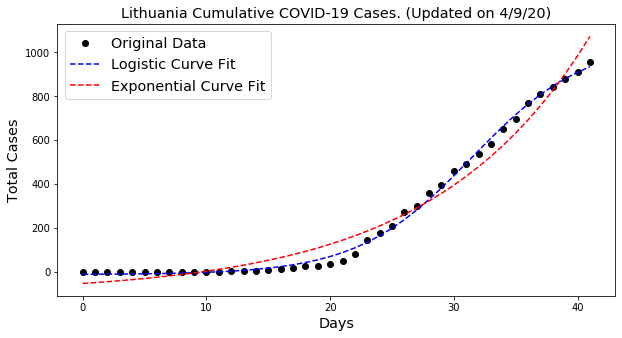



Azerbaijan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 926
	Confirmed cases on 4/2/20 	 400
	Ratio: 2.32
	Weekly increase: 131.5 %
	Daily increase: 12.7 % per day
	Doubling Time (represents recent growth): 5.8 days

** Based on Logistic Fit**

	R^2: 0.9987703433991173
	Doubling Time (during middle of growth):  7.89 (± 0.57 ) days
	param:  [ 1.13453023e+03  1.75759225e-01 -2.17945041e-01  1.99535375e+03]

** Based on Exponential Fit **

	R^2: 0.996552788319466
	Doubling Time (represents overall growth):  5.45 (± 0.24 ) days
	param:  [  6.72075466   0.12728076 -16.49686097]


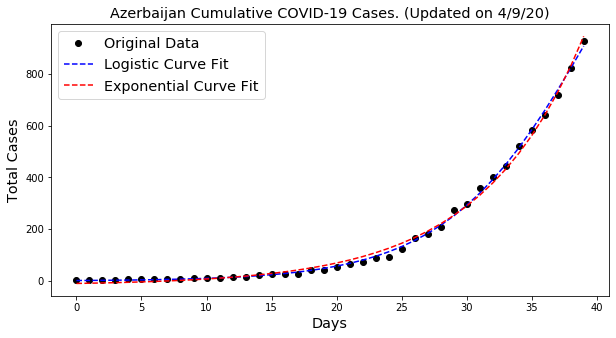



Armenia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 921
	Confirmed cases on 4/2/20 	 663
	Ratio: 1.39
	Weekly increase: 38.9 %
	Daily increase: 4.8 % per day
	Doubling Time (represents recent growth): 14.8 days

** Based on Logistic Fit**

	R^2: 0.9969723931718891
	Doubling Time (during middle of growth):  7.67 (± 0.74 ) days
	param:  [ 2.27855818e+02  1.80774503e-01 -1.42954533e+01  1.11654814e+03]

** Based on Exponential Fit **

	R^2: 0.9794730128220246
	Doubling Time (represents overall growth):  9.45 (± 1.42 ) days
	param:  [ 6.53432676e+01  7.33469643e-02 -1.00000000e+02]


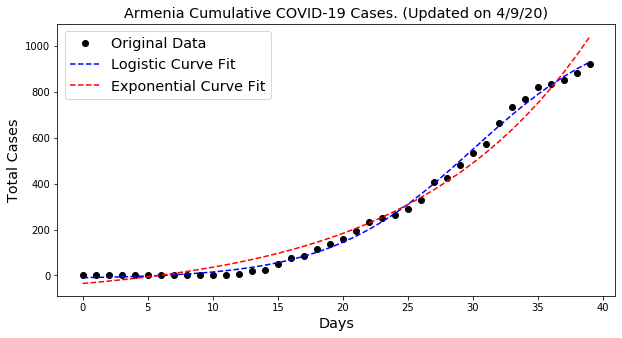



Kuwait

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 910
	Confirmed cases on 4/2/20 	 342
	Ratio: 2.66
	Weekly increase: 166.1 %
	Daily increase: 15.0 % per day
	Doubling Time (represents recent growth): 5.0 days

** Based on Logistic Fit**

	R^2: 0.9842215446380026
	Doubling Time (during middle of growth):  10.79 (± 1.02 ) days
	param:  [1.56072181e+10 1.28524487e-01 5.41204728e+01 4.13560488e+10]

** Based on Exponential Fit **

	R^2: 0.9842215448885172
	Doubling Time (represents overall growth):  5.39 (± 0.46 ) days
	param:  [ 2.64982398  0.1285243  54.1203116 ]


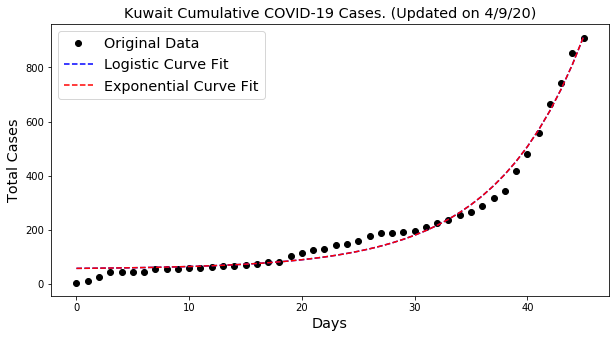



Bahrain

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 887
	Confirmed cases on 4/2/20 	 643
	Ratio: 1.38
	Weekly increase: 37.9 %
	Daily increase: 4.7 % per day
	Doubling Time (represents recent growth): 15.1 days

** Based on Logistic Fit**

	R^2: 0.995300860173417
	Doubling Time (during middle of growth):  23.84 (± 8.16 ) days
	param:  [ 2.61251400e+01  5.81430911e-02 -1.02140320e+02  2.72226015e+03]

** Based on Exponential Fit **

	R^2: 0.9912885797854539
	Doubling Time (represents overall growth):  13.6 (± 1.43 ) days
	param:  [ 1.00000000e+02  5.09554863e-02 -7.70264262e+01]


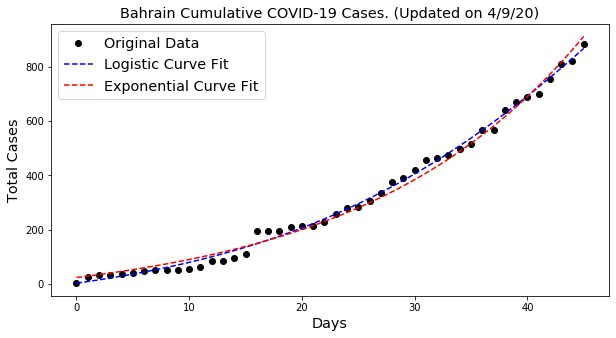



Bosnia and Herzegovina

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 858
	Confirmed cases on 4/2/20 	 533
	Ratio: 1.61
	Weekly increase: 61.0 %
	Daily increase: 7.0 % per day
	Doubling Time (represents recent growth): 10.2 days

** Based on Logistic Fit**

	R^2: 0.9981061415298935
	Doubling Time (during middle of growth):  7.62 (± 0.67 ) days
	param:  [ 1.90395334e+02  1.81818231e-01 -9.31943876e+00  1.12334019e+03]

** Based on Exponential Fit **

	R^2: 0.9890891702822032
	Doubling Time (represents overall growth):  8.5 (± 0.97 ) days
	param:  [ 5.79741420e+01  8.15207879e-02 -9.40581417e+01]


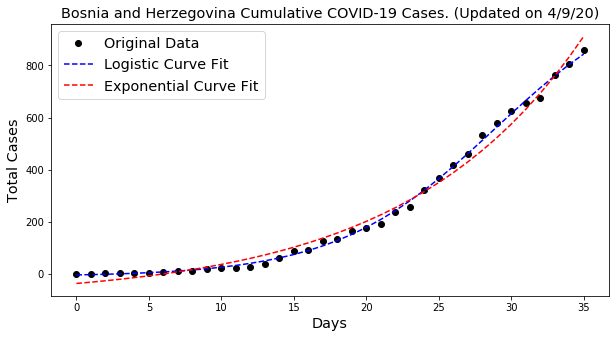



Kazakhstan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 781
	Confirmed cases on 4/2/20 	 435
	Ratio: 1.8
	Weekly increase: 79.5 %
	Daily increase: 8.7 % per day
	Doubling Time (represents recent growth): 8.3 days

** Based on Logistic Fit**

	R^2: 0.9956310993927384
	Doubling Time (during middle of growth):  6.18 (± 0.96 ) days
	param:  [ 1.08415264e+02  2.24288946e-01 -2.76929892e+00  9.69466952e+02]

** Based on Exponential Fit **

	R^2: 0.9845065312048467
	Doubling Time (represents overall growth):  7.66 (± 1.34 ) days
	param:  [ 8.19149249e+01  9.04700355e-02 -1.00000000e+02]


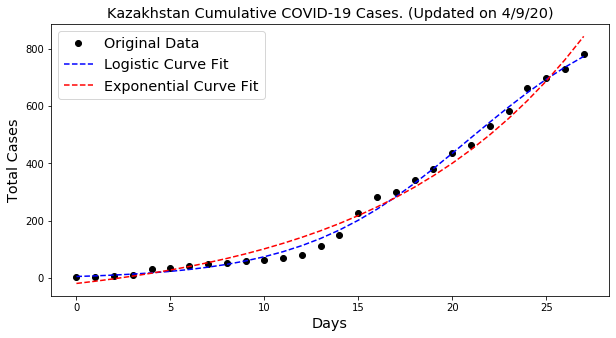



Cameroon

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 730
	Confirmed cases on 4/2/20 	 306
	Ratio: 2.39
	Weekly increase: 138.6 %
	Daily increase: 13.2 % per day
	Doubling Time (represents recent growth): 5.6 days

** Based on Logistic Fit**

	R^2: 0.9883063810250153
	Doubling Time (during middle of growth):  3.0 (± 0.54 ) days
	param:  [3.06010011e+05 4.61987223e-01 1.74946641e+01 7.75349761e+02]

** Based on Exponential Fit **

	R^2: 0.9513397787925394
	Doubling Time (represents overall growth):  5.48 (± 1.08 ) days
	param:  [ 12.20927315   0.12644343 -39.49158936]


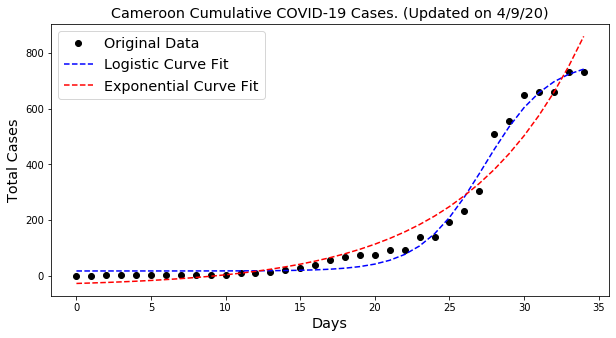



Diamond Princess

** Based on Logistic Fit**

	R^2: 0.9963099717081801
	Doubling Time (during middle of growth):  2.82 (± 0.22 ) days
	param:  [8.98673481e+01 4.91149872e-01 6.86562051e+01 7.08646113e+02]

 exponential R^2  -0.5724652853960788


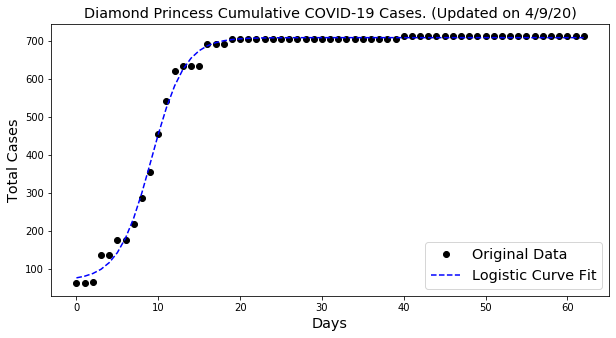



Slovakia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 701
	Confirmed cases on 4/2/20 	 426
	Ratio: 1.65
	Weekly increase: 64.6 %
	Daily increase: 7.4 % per day
	Doubling Time (represents recent growth): 9.7 days

** Based on Logistic Fit**

	R^2: 0.9943831212364191
	Doubling Time (during middle of growth):  25.24 (± 14.93 ) days
	param:  [ 2.02725020e+07  5.49313313e-02 -1.46446718e+02  2.60677584e+09]

** Based on Exponential Fit **

	R^2: 0.9933842158874552
	Doubling Time (represents overall growth):  11.12 (± 1.25 ) days
	param:  [ 9.57432493e+01  6.23458723e-02 -1.00000000e+02]


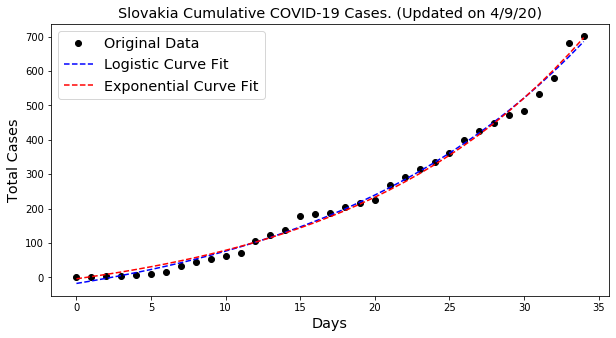



North Macedonia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 663
	Confirmed cases on 4/2/20 	 384
	Ratio: 1.73
	Weekly increase: 72.7 %
	Daily increase: 8.1 % per day
	Doubling Time (represents recent growth): 8.9 days

** Based on Logistic Fit**

	R^2: 0.9966914011978673
	Doubling Time (during middle of growth):  8.49 (± 0.86 ) days
	param:  [ 4.52715567e+02  1.63248124e-01 -8.82982242e+00  9.34467445e+02]

** Based on Exponential Fit **

	R^2: 0.9876447292657868
	Doubling Time (represents overall growth):  8.19 (± 0.77 ) days
	param:  [ 20.08241707   0.08463631 -46.92901963]


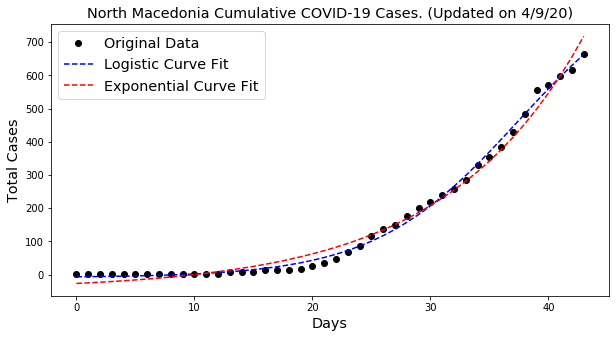



Tunisia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 643
	Confirmed cases on 4/2/20 	 455
	Ratio: 1.41
	Weekly increase: 41.3 %
	Daily increase: 5.1 % per day
	Doubling Time (represents recent growth): 14.0 days

** Based on Logistic Fit**

	R^2: 0.9982531284099541
	Doubling Time (during middle of growth):  5.71 (± 0.4 ) days
	param:  [ 5.84574340e+02  2.42863407e-01 -1.22239676e+00  7.08219267e+02]

** Based on Exponential Fit **

	R^2: 0.9703088290620826
	Doubling Time (represents overall growth):  9.55 (± 1.9 ) days
	param:  [ 6.16109927e+01  7.26059976e-02 -1.00000000e+02]


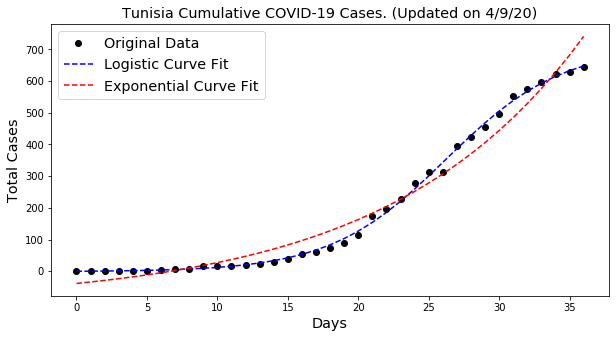



Bulgaria

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 618
	Confirmed cases on 4/2/20 	 457
	Ratio: 1.35
	Weekly increase: 35.2 %
	Daily increase: 4.4 % per day
	Doubling Time (represents recent growth): 16.1 days

** Based on Logistic Fit**

	R^2: 0.9984374809550424
	Doubling Time (during middle of growth):  10.61 (± 1.23 ) days
	param:  [ 1.68714328e+01  1.30715588e-01 -5.79643091e+01  7.85462394e+02]

** Based on Exponential Fit **

	R^2: 0.9732232062841812
	Doubling Time (represents overall growth):  10.81 (± 2.64 ) days
	param:  [ 1.00000000e+02  6.41441835e-02 -8.22669924e+01]


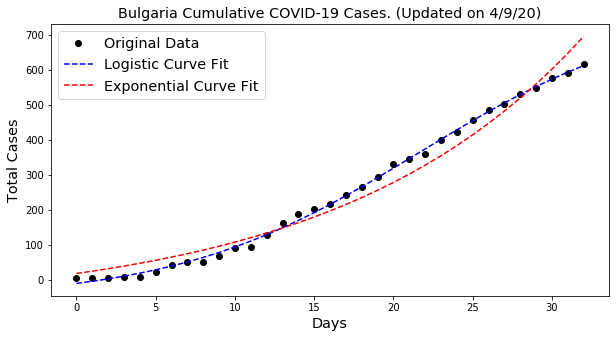



Latvia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 589
	Confirmed cases on 4/2/20 	 458
	Ratio: 1.29
	Weekly increase: 28.6 %
	Daily increase: 3.7 % per day
	Doubling Time (represents recent growth): 19.3 days

** Based on Logistic Fit**

	R^2: 0.9991615629600056
	Doubling Time (during middle of growth):  7.01 (± 0.34 ) days
	param:  [ 1.72679053e+02  1.97670665e-01 -9.07859572e+00  6.40002808e+02]

** Based on Exponential Fit **

	R^2: 0.9712927409273221
	Doubling Time (represents overall growth):  11.44 (± 2.43 ) days
	param:  [ 7.77575038e+01  6.05660182e-02 -1.00000000e+02]


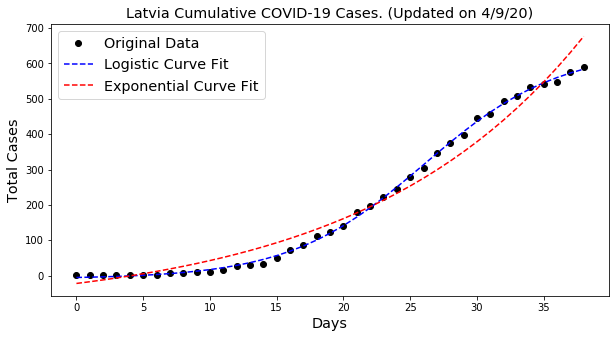



Andorra

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 583
	Confirmed cases on 4/2/20 	 428
	Ratio: 1.36
	Weekly increase: 36.2 %
	Daily increase: 4.5 % per day
	Doubling Time (represents recent growth): 15.7 days

** Based on Logistic Fit**

	R^2: 0.9961995326259088
	Doubling Time (during middle of growth):  6.42 (± 0.64 ) days
	param:  [ 2.99910561e+02  2.16023299e-01 -1.19349149e+01  6.07963879e+02]

** Based on Exponential Fit **

	R^2: 0.9680367599854589
	Doubling Time (represents overall growth):  10.82 (± 2.31 ) days
	param:  [ 6.63831253e+01  6.40347402e-02 -1.00000000e+02]


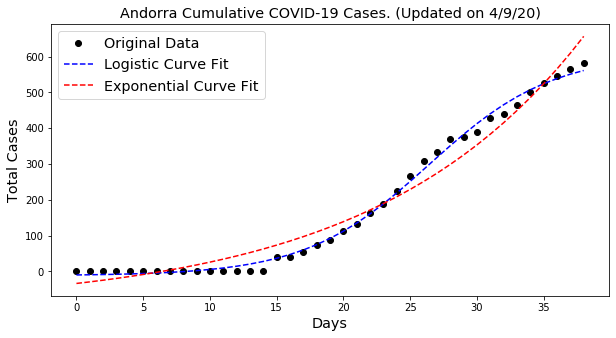



Lebanon

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 582
	Confirmed cases on 4/2/20 	 494
	Ratio: 1.18
	Weekly increase: 17.8 %
	Daily increase: 2.4 % per day
	Doubling Time (represents recent growth): 29.6 days

** Based on Logistic Fit**

	R^2: 0.9977342885641792
	Doubling Time (during middle of growth):  7.32 (± 0.48 ) days
	param:  [4.27046714e+02 1.89510142e-01 1.00524756e+00 5.93020391e+02]

** Based on Exponential Fit **

	R^2: 0.9600571643318139
	Doubling Time (represents overall growth):  14.46 (± 3.24 ) days
	param:  [ 7.77626834e+01  4.79253851e-02 -1.00000000e+02]


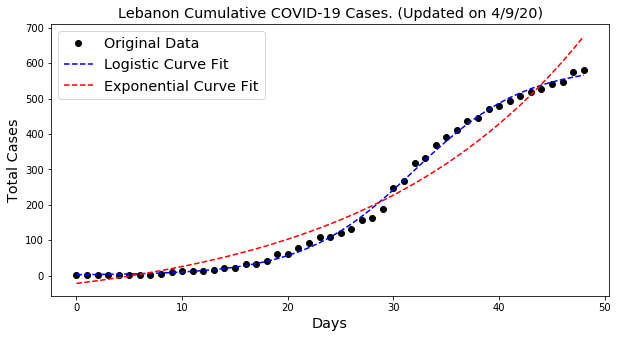



Uzbekistan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 582
	Confirmed cases on 4/2/20 	 205
	Ratio: 2.84
	Weekly increase: 183.9 %
	Daily increase: 16.1 % per day
	Doubling Time (represents recent growth): 4.6 days

** Based on Logistic Fit**

	R^2: 0.9869506953806111
	Doubling Time (during middle of growth):  7.37 (± 2.85 ) days
	param:  [2.04153798e+02 1.88180928e-01 5.88279742e+00 1.73164808e+03]

** Based on Exponential Fit **

	R^2: 0.9860340311341126
	Doubling Time (represents overall growth):  4.92 (± 0.66 ) days
	param:  [ 18.74195102   0.14090932 -12.30482047]


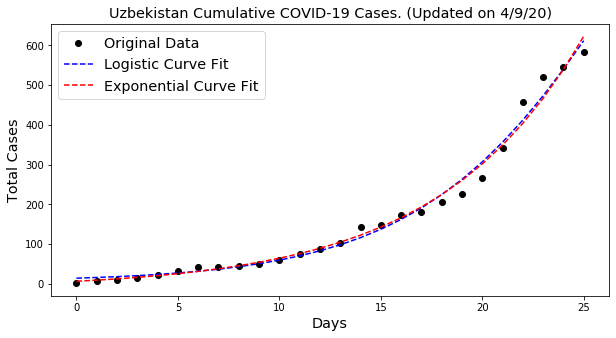



Cyprus

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 564
	Confirmed cases on 4/2/20 	 356
	Ratio: 1.58
	Weekly increase: 58.4 %
	Daily increase: 6.8 % per day
	Doubling Time (represents recent growth): 10.5 days

** Based on Logistic Fit**

	R^2: 0.9962466933802494
	Doubling Time (during middle of growth):  8.6 (± 1.36 ) days
	param:  [ 6.44124824e+01  1.61110760e-01 -4.92323237e+00  8.09962101e+02]

** Based on Exponential Fit **

	R^2: 0.9912371487637105
	Doubling Time (represents overall growth):  9.77 (± 1.28 ) days
	param:  [ 7.55155340e+01  7.09175318e-02 -8.84357127e+01]


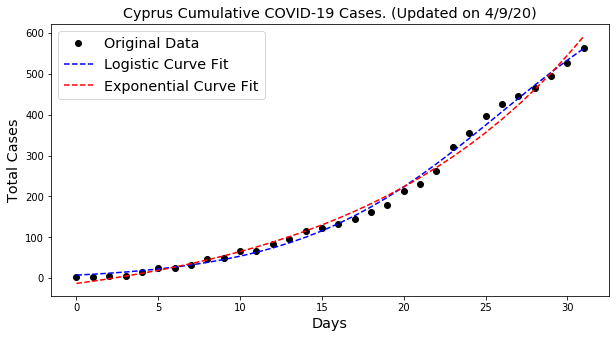



Costa Rica

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 539
	Confirmed cases on 4/2/20 	 396
	Ratio: 1.36
	Weekly increase: 36.1 %
	Daily increase: 4.5 % per day
	Doubling Time (represents recent growth): 15.7 days

** Based on Logistic Fit**

	R^2: 0.9975774474704818
	Doubling Time (during middle of growth):  7.5 (± 0.71 ) days
	param:  [ 5.78664905e+01  1.84932117e-01 -1.38591043e+01  5.67099945e+02]

** Based on Exponential Fit **

	R^2: 0.9724056525333565
	Doubling Time (represents overall growth):  11.95 (± 2.99 ) days
	param:  [ 9.60143419e+01  5.80258207e-02 -1.00000000e+02]


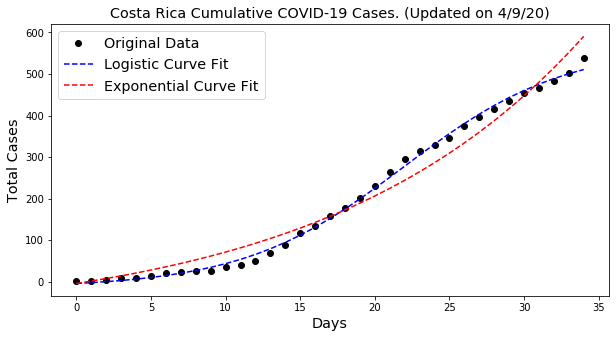



Cuba

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 515
	Confirmed cases on 4/2/20 	 233
	Ratio: 2.21
	Weekly increase: 121.0 %
	Daily increase: 12.0 % per day
	Doubling Time (represents recent growth): 6.1 days

** Based on Logistic Fit**

	R^2: 0.9956511304757286
	Doubling Time (during middle of growth):  9.26 (± 2.12 ) days
	param:  [ 9.45196819e+01  1.49639236e-01 -2.05526887e+01  1.24353473e+03]

** Based on Exponential Fit **

	R^2: 0.9945329568731054
	Doubling Time (represents overall growth):  6.58 (± 0.58 ) days
	param:  [ 29.13863705   0.10531336 -42.7718444 ]


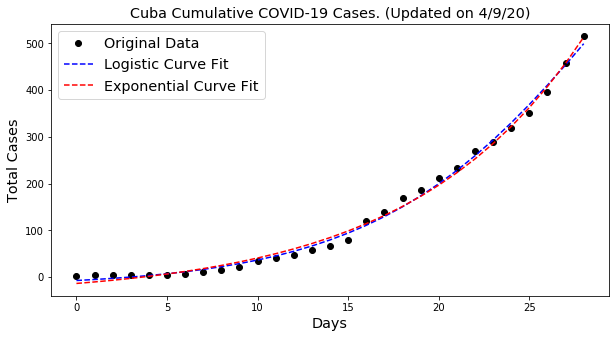



Afghanistan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 484
	Confirmed cases on 4/2/20 	 273
	Ratio: 1.77
	Weekly increase: 77.3 %
	Daily increase: 8.5 % per day
	Doubling Time (represents recent growth): 8.5 days

** Based on Logistic Fit**

	R^2: 0.9963809102621747
	Doubling Time (during middle of growth):  7.17 (± 0.71 ) days
	param:  [2.87769595e+03 1.93423475e-01 3.04002603e-01 7.07047876e+02]

** Based on Exponential Fit **

	R^2: 0.9887753321088741
	Doubling Time (represents overall growth):  6.23 (± 0.47 ) days
	param:  [  3.55924043   0.11119416 -13.6116533 ]


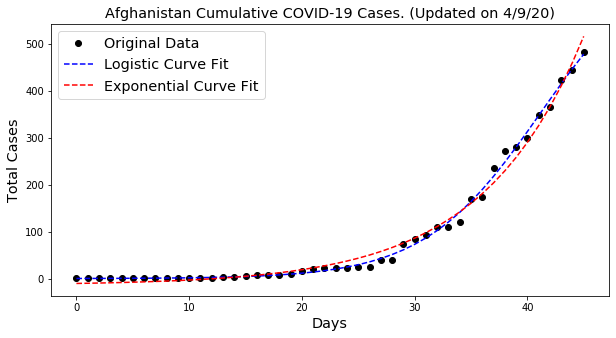



Oman

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 457
	Confirmed cases on 4/2/20 	 231
	Ratio: 1.98
	Weekly increase: 97.8 %
	Daily increase: 10.2 % per day
	Doubling Time (represents recent growth): 7.1 days

** Based on Logistic Fit**

	R^2: 0.9965368397808845
	Doubling Time (during middle of growth):  11.05 (± 1.41 ) days
	param:  [5.63648238e+02 1.25460362e-01 4.22751910e-01 1.33829588e+03]

** Based on Exponential Fit **

	R^2: 0.995636504101257
	Doubling Time (represents overall growth):  6.94 (± 0.34 ) days
	param:  [ 5.2163476   0.09985203 -6.32137912]


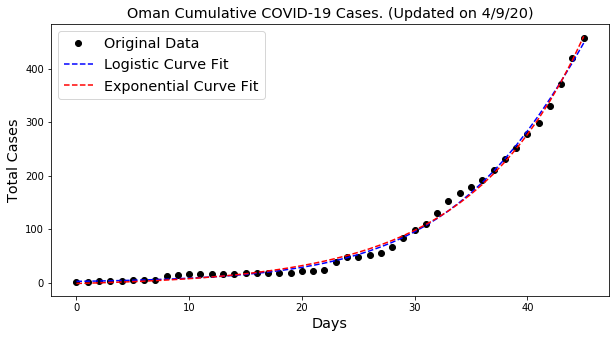



Uruguay

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 456
	Confirmed cases on 4/2/20 	 350
	Ratio: 1.3
	Weekly increase: 30.3 %
	Daily increase: 3.9 % per day
	Doubling Time (represents recent growth): 18.3 days

** Based on Logistic Fit**

	R^2: 0.9954357381489268
	Doubling Time (during middle of growth):  9.5 (± 2.35 ) days
	param:  [ 4.71036149e+00  1.45971383e-01 -1.16176560e+02  5.00706345e+02]

 exponential R^2  0.9077344005991567


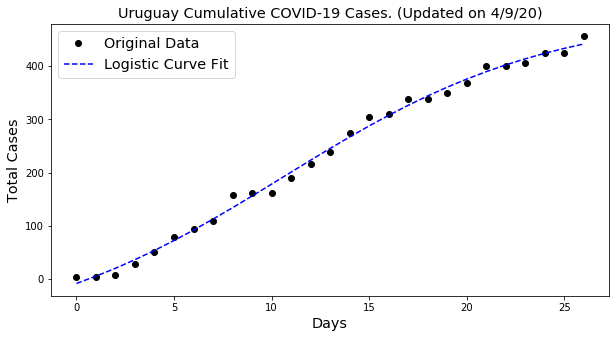



Cote d'Ivoire

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 444
	Confirmed cases on 4/2/20 	 194
	Ratio: 2.29
	Weekly increase: 128.9 %
	Daily increase: 12.6 % per day
	Doubling Time (represents recent growth): 5.9 days

** Based on Logistic Fit**

	R^2: 0.9857827347887037
	Doubling Time (during middle of growth):  13.37 (± 8.46 ) days
	param:  [ 1.16084473e+02  1.03712087e-01 -4.14613343e+01  3.12886902e+03]

** Based on Exponential Fit **

	R^2: 0.9857047817257087
	Doubling Time (represents overall growth):  7.54 (± 1.14 ) days
	param:  [ 33.54128569   0.09188875 -49.3499272 ]


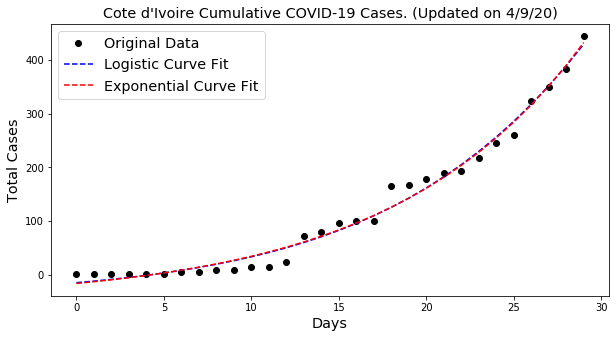



Burkina Faso

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 443
	Confirmed cases on 4/2/20 	 288
	Ratio: 1.54
	Weekly increase: 53.8 %
	Daily increase: 6.3 % per day
	Doubling Time (represents recent growth): 11.3 days

** Based on Logistic Fit**

	R^2: 0.9939221359845349
	Doubling Time (during middle of growth):  8.76 (± 1.81 ) days
	param:  [ 2.48175700e+01  1.58231132e-01 -3.47387732e+01  5.15499040e+02]

** Based on Exponential Fit **

	R^2: 0.9798629341347668
	Doubling Time (represents overall growth):  11.46 (± 2.78 ) days
	param:  [ 9.24256677e+01  6.05006878e-02 -1.00000000e+02]


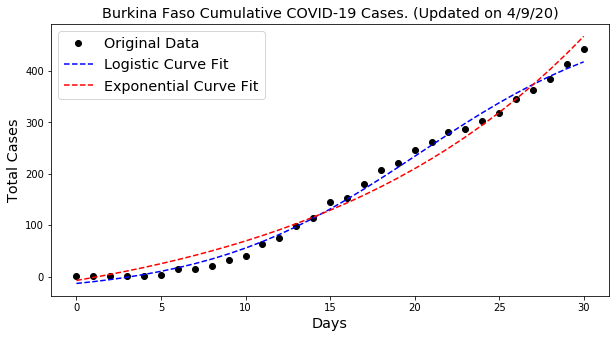



Niger

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 410
	Confirmed cases on 4/2/20 	 98
	Ratio: 4.18
	Weekly increase: 318.4 %
	Daily increase: 22.7 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Logistic Fit**

	R^2: 0.995707349347085
	Doubling Time (during middle of growth):  4.31 (± 0.83 ) days
	param:  [ 4.56882198e+02  3.21653108e-01 -3.21484016e+00  7.02545560e+02]

** Based on Exponential Fit **

	R^2: 0.9913139167065579
	Doubling Time (represents overall growth):  3.48 (± 0.39 ) days
	param:  [  8.20520967   0.19911307 -18.02272453]


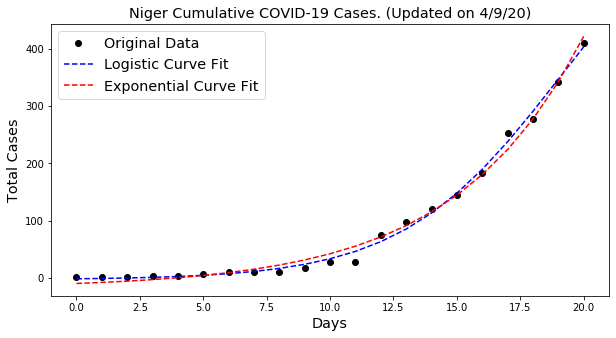



Albania

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 409
	Confirmed cases on 4/2/20 	 277
	Ratio: 1.48
	Weekly increase: 47.7 %
	Daily increase: 5.7 % per day
	Doubling Time (represents recent growth): 12.5 days

** Based on Logistic Fit**

	R^2: 0.9964719987279721
	Doubling Time (during middle of growth):  10.08 (± 1.78 ) days
	param:  [ 2.53652824e+01  1.37463580e-01 -1.16105355e+01  5.70055140e+02]

** Based on Exponential Fit **

	R^2: 0.9906498524482661
	Doubling Time (represents overall growth):  12.71 (± 2.15 ) days
	param:  [ 1.00000000e+02  5.45346591e-02 -9.68073400e+01]


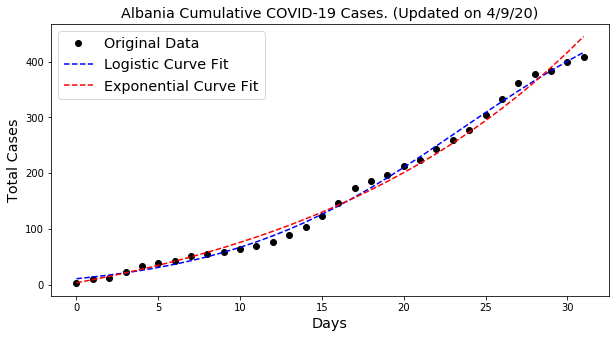



Taiwan*

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 380
	Confirmed cases on 4/2/20 	 339
	Ratio: 1.12
	Weekly increase: 12.1 %
	Daily increase: 1.6 % per day
	Doubling Time (represents recent growth): 42.5 days

** Based on Logistic Fit**

	R^2: 0.994125319521376
	Doubling Time (during middle of growth):  6.78 (± 0.56 ) days
	param:  [3.17842619e+05 2.04566007e-01 1.92528827e+01 3.93806904e+02]

** Based on Exponential Fit **

	R^2: 0.9564231017538619
	Doubling Time (represents overall growth):  12.54 (± 1.51 ) days
	param:  [ 6.23232795  0.05527715 -9.42213488]


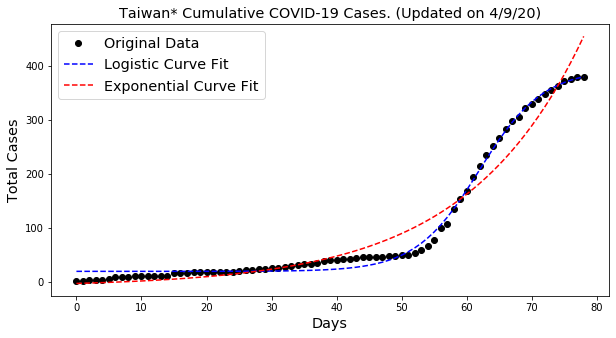



Ghana

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 378
	Confirmed cases on 4/2/20 	 204
	Ratio: 1.85
	Weekly increase: 85.3 %
	Daily increase: 9.2 % per day
	Doubling Time (represents recent growth): 7.9 days

** Based on Logistic Fit**

	R^2: 0.9532625577413085
	Doubling Time (during middle of growth):  27.3 (± 132.42 ) days
	param:  [ 1.04638985e+06  5.07858125e-02 -1.40582337e+02  1.32695349e+08]

** Based on Exponential Fit **

	R^2: 0.9523899280816077
	Doubling Time (represents overall growth):  11.58 (± 5.32 ) days
	param:  [ 9.28104149e+01  5.98530776e-02 -1.00000000e+02]


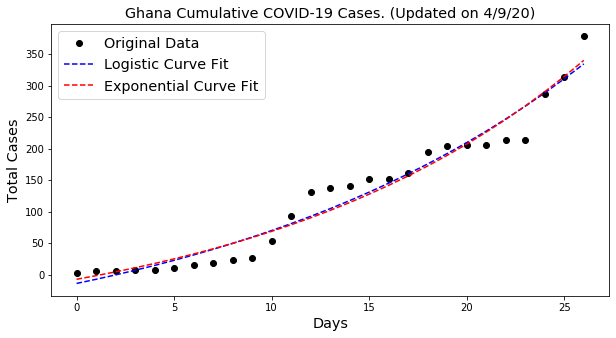



Jordan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 372
	Confirmed cases on 4/2/20 	 299
	Ratio: 1.24
	Weekly increase: 24.4 %
	Daily increase: 3.2 % per day
	Doubling Time (represents recent growth): 22.2 days

** Based on Logistic Fit**

	R^2: 0.9948406046721218
	Doubling Time (during middle of growth):  5.98 (± 0.68 ) days
	param:  [ 1.73513488e+02  2.31908061e-01 -9.87293448e+00  3.66465309e+02]

 exponential R^2  0.9496706760822041


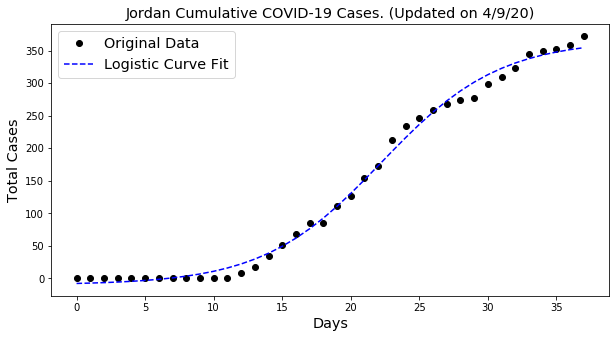



Honduras

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 343
	Confirmed cases on 4/2/20 	 219
	Ratio: 1.57
	Weekly increase: 56.6 %
	Daily increase: 6.6 % per day
	Doubling Time (represents recent growth): 10.8 days

** Based on Logistic Fit**

	R^2: 0.9965563735860918
	Doubling Time (during middle of growth):  4.98 (± 0.56 ) days
	param:  [3.76662894e+02 2.78195094e-01 2.33018646e+00 3.72463145e+02]

** Based on Exponential Fit **

	R^2: 0.9748301390225828
	Doubling Time (represents overall growth):  8.25 (± 1.77 ) days
	param:  [ 37.39094683   0.08406648 -55.3033574 ]


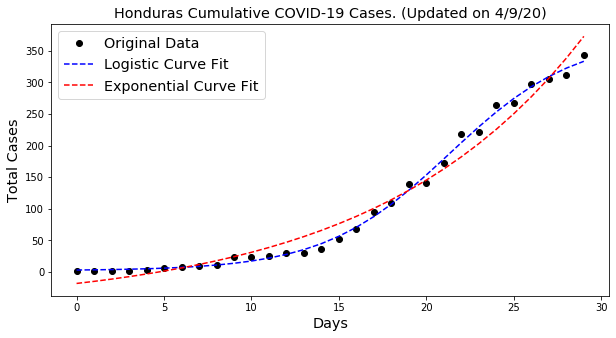



Malta

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 337
	Confirmed cases on 4/2/20 	 196
	Ratio: 1.72
	Weekly increase: 71.9 %
	Daily increase: 8.1 % per day
	Doubling Time (represents recent growth): 9.0 days

** Based on Logistic Fit**

	R^2: 0.9864771492276697
	Doubling Time (during middle of growth):  30.3 (± 35.23 ) days
	param:  [ 3.62014559e+06  4.57524590e-02 -1.00954659e+02  3.32597405e+08]

** Based on Exponential Fit **

	R^2: 0.9864764449921297
	Doubling Time (represents overall growth):  15.08 (± 3.27 ) days
	param:  [ 9.10877065e+01  4.59545479e-02 -1.00000000e+02]


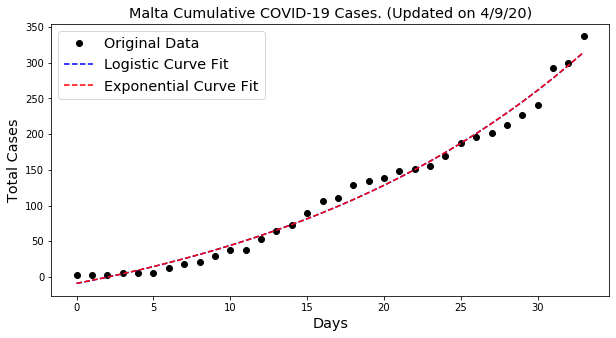



San Marino

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 333
	Confirmed cases on 4/2/20 	 245
	Ratio: 1.36
	Weekly increase: 35.9 %
	Daily increase: 4.5 % per day
	Doubling Time (represents recent growth): 15.8 days

** Based on Logistic Fit**

	R^2: 0.9897732175366828
	Doubling Time (during middle of growth):  11.98 (± 2.58 ) days
	param:  [ 1.28170391e+01  1.15726869e-01 -3.19227179e+01  3.19443004e+02]

** Based on Exponential Fit **

	R^2: 0.9541553914201549
	Doubling Time (represents overall growth):  20.01 (± 7.58 ) days
	param:  [ 1.00000000e+02  3.46392705e-02 -9.00753862e+01]


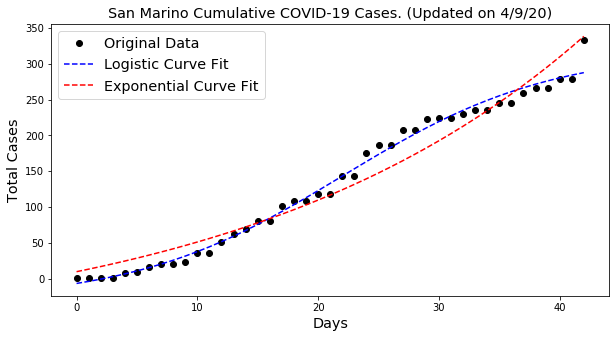



Bangladesh

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 330
	Confirmed cases on 4/2/20 	 56
	Ratio: 5.89
	Weekly increase: 489.3 %
	Daily increase: 28.8 % per day
	Doubling Time (represents recent growth): 2.7 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.9557587651102923
	Doubling Time (represents overall growth):  2.14 (± 0.35 ) days
	param:  [9.45113308e-03 3.23153335e-01 1.96938793e+01]


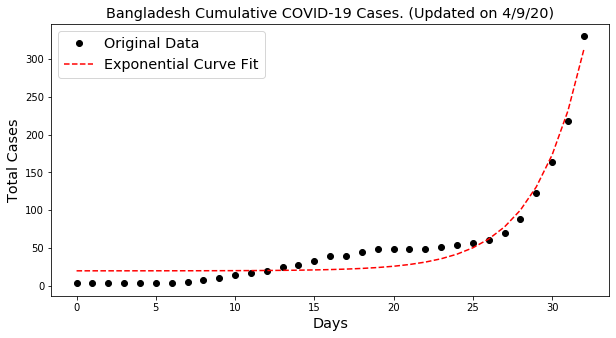



Mauritius

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 314
	Confirmed cases on 4/2/20 	 169
	Ratio: 1.86
	Weekly increase: 85.8 %
	Daily increase: 9.3 % per day
	Doubling Time (represents recent growth): 7.8 days

** Based on Logistic Fit**

	R^2: 0.9954443634729273
	Doubling Time (during middle of growth):  20.45 (± 25.98 ) days
	param:  [ 1.30569290e+01  6.77741043e-02 -1.25954165e+02  1.57556445e+03]

** Based on Exponential Fit **

	R^2: 0.9930106839205614
	Doubling Time (represents overall growth):  10.75 (± 2.19 ) days
	param:  [ 1.00000000e+02  6.44501817e-02 -9.70945588e+01]


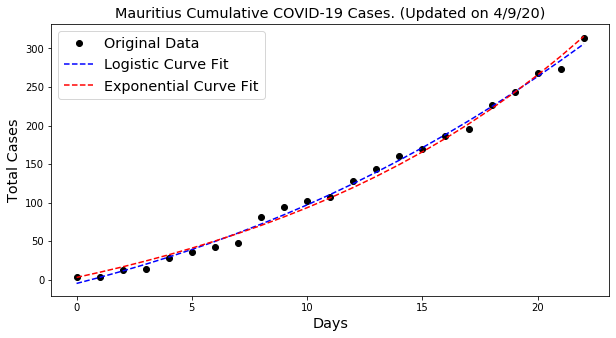



Nigeria

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 288
	Confirmed cases on 4/2/20 	 184
	Ratio: 1.57
	Weekly increase: 56.5 %
	Daily increase: 6.6 % per day
	Doubling Time (represents recent growth): 10.8 days

** Based on Logistic Fit**

	R^2: 0.9977421987384979
	Doubling Time (during middle of growth):  5.71 (± 0.42 ) days
	param:  [ 2.79982933e+03  2.42777415e-01 -7.32243349e-01  3.17280244e+02]

** Based on Exponential Fit **

	R^2: 0.9740678846717392
	Doubling Time (represents overall growth):  7.58 (± 1.04 ) days
	param:  [  8.03311241   0.09145239 -21.61339011]


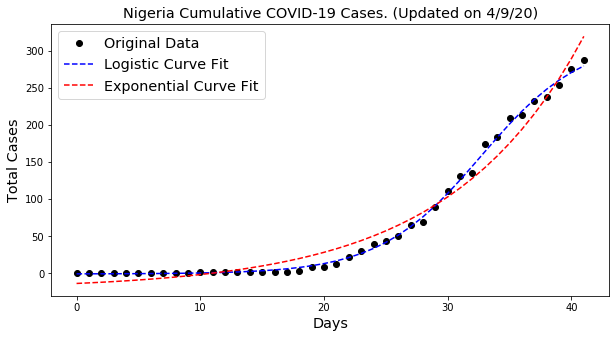



Kyrgyzstan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 280
	Confirmed cases on 4/2/20 	 116
	Ratio: 2.41
	Weekly increase: 141.4 %
	Daily increase: 13.4 % per day
	Doubling Time (represents recent growth): 5.5 days

** Based on Logistic Fit**

	R^2: 0.9834215867578715
	Doubling Time (during middle of growth):  13.4 (± 8.16 ) days
	param:  [ 4.42443022e+07  1.03484443e-01 -2.87444438e+01  1.42168194e+09]

** Based on Exponential Fit **

	R^2: 0.983421587595626
	Doubling Time (represents overall growth):  6.7 (± 1.41 ) days
	param:  [ 32.13234499   0.10348469 -28.74415503]


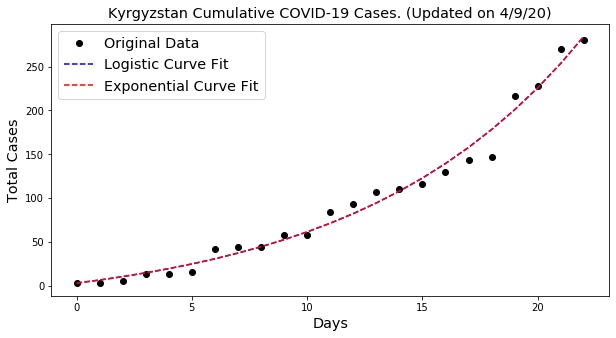



Bolivia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 264
	Confirmed cases on 4/2/20 	 123
	Ratio: 2.15
	Weekly increase: 114.6 %
	Daily increase: 11.5 % per day
	Doubling Time (represents recent growth): 6.4 days

** Based on Logistic Fit**

	R^2: 0.9888396390650863
	Doubling Time (during middle of growth):  12.51 (± 6.39 ) days
	param:  [ 1.11443883e+02  1.10773654e-01 -1.39062990e+01  1.41361018e+03]

** Based on Exponential Fit **

	R^2: 0.9887238800827821
	Doubling Time (represents overall growth):  7.25 (± 0.94 ) days
	param:  [ 16.72568226   0.09560478 -18.97370078]


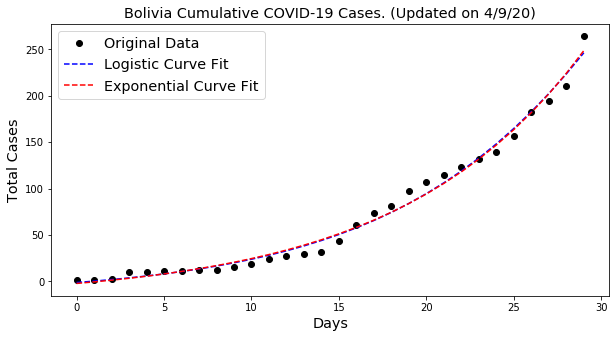



West Bank and Gaza

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 263
	Confirmed cases on 4/2/20 	 161
	Ratio: 1.63
	Weekly increase: 63.4 %
	Daily increase: 7.3 % per day
	Doubling Time (represents recent growth): 9.9 days

** Based on Logistic Fit**

	R^2: 0.9859074707777957
	Doubling Time (during middle of growth):  7.09 (± 1.67 ) days
	param:  [3.27078766e+02 1.95598408e-01 2.17750329e+01 3.72562699e+02]

** Based on Exponential Fit **

	R^2: 0.9775861224443705
	Doubling Time (represents overall growth):  7.91 (± 1.24 ) days
	param:  [14.07617742  0.08759432 -2.99009199]


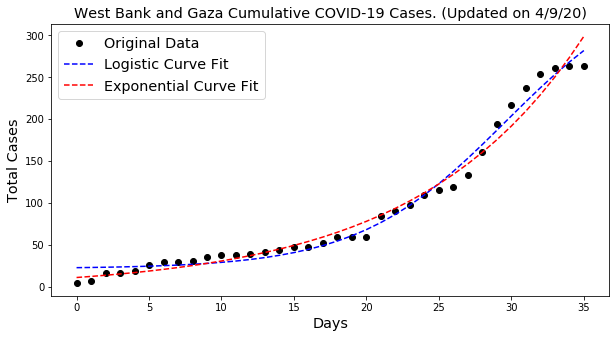



Vietnam

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 255
	Confirmed cases on 4/2/20 	 233
	Ratio: 1.09
	Weekly increase: 9.4 %
	Daily increase: 1.3 % per day
	Doubling Time (represents recent growth): 53.8 days

** Based on Logistic Fit**

	R^2: 0.9968723691512148
	Doubling Time (during middle of growth):  8.43 (± 0.51 ) days
	param:  [2.69244785e+04 1.64496362e-01 1.00637092e+01 2.80618187e+02]

** Based on Exponential Fit **

	R^2: 0.9660021727010787
	Doubling Time (represents overall growth):  12.46 (± 1.34 ) days
	param:  [ 4.26014771  0.05564344 -6.90507829]


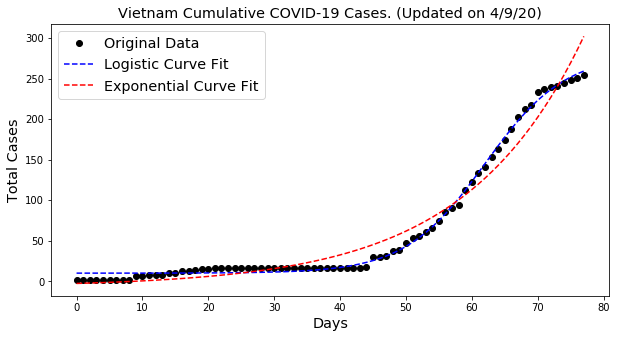



Montenegro

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 252
	Confirmed cases on 4/2/20 	 144
	Ratio: 1.75
	Weekly increase: 75.0 %
	Daily increase: 8.3 % per day
	Doubling Time (represents recent growth): 8.7 days

** Based on Logistic Fit**

	R^2: 0.9886799367382457
	Doubling Time (during middle of growth):  7.67 (± 2.92 ) days
	param:  [ 2.23135377e+01  1.80816622e-01 -1.39046195e+01  3.61525027e+02]

** Based on Exponential Fit **

	R^2: 0.9834584036802863
	Doubling Time (represents overall growth):  11.49 (± 3.6 ) days
	param:  [ 9.42897174e+01  6.03361874e-02 -1.00000000e+02]


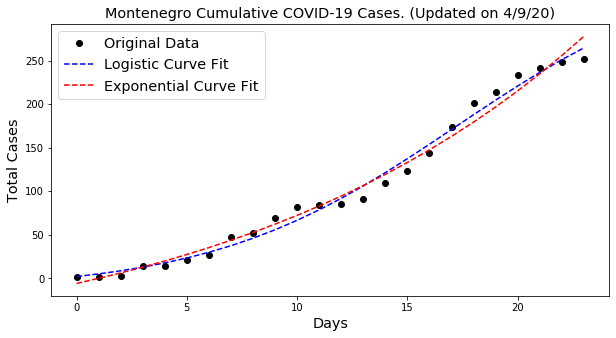



Senegal

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 250
	Confirmed cases on 4/2/20 	 195
	Ratio: 1.28
	Weekly increase: 28.2 %
	Daily increase: 3.6 % per day
	Doubling Time (represents recent growth): 19.5 days

** Based on Logistic Fit**

	R^2: 0.9983323253255485
	Doubling Time (during middle of growth):  6.89 (± 0.47 ) days
	param:  [ 1.87083742e+02  2.01107187e-01 -1.04459212e+00  2.69366660e+02]

** Based on Exponential Fit **

	R^2: 0.9738086899095999
	Doubling Time (represents overall growth):  14.14 (± 3.34 ) days
	param:  [ 5.44812512e+01  4.90327384e-02 -7.22979986e+01]


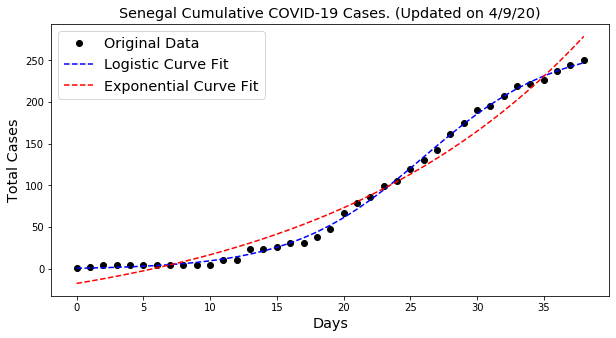



Georgia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 218
	Confirmed cases on 4/2/20 	 134
	Ratio: 1.63
	Weekly increase: 62.7 %
	Daily increase: 7.2 % per day
	Doubling Time (represents recent growth): 10.0 days

** Based on Logistic Fit**

	R^2: 0.9963430432563802
	Doubling Time (during middle of growth):  17.96 (± 4.11 ) days
	param:  [ 1.65631725e+02  7.71731021e-02 -1.09493728e+01  1.64116967e+03]

** Based on Exponential Fit **

	R^2: 0.9962623986865903
	Doubling Time (represents overall growth):  10.07 (± 0.58 ) days
	param:  [ 12.49127515   0.06884677 -14.42008271]


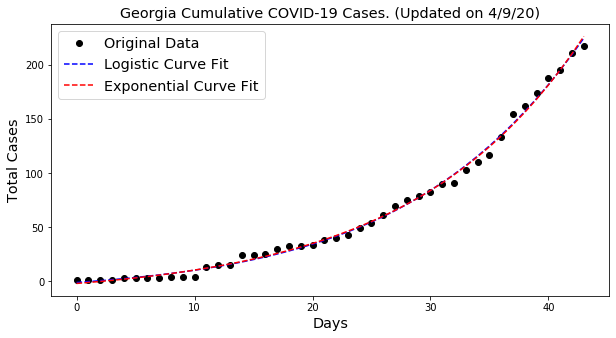



Guinea

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 194
	Confirmed cases on 4/2/20 	 52
	Ratio: 3.73
	Weekly increase: 273.1 %
	Daily increase: 20.7 % per day
	Doubling Time (represents recent growth): 3.7 days

** Based on Logistic Fit**

	R^2: 0.9908249691856749
	Doubling Time (during middle of growth):  3.3 (± 0.62 ) days
	param:  [1.30245146e+04 4.20159392e-01 1.01644017e+00 2.09979858e+02]

** Based on Exponential Fit **

	R^2: 0.9714956359155398
	Doubling Time (represents overall growth):  4.01 (± 0.65 ) days
	param:  [ 1.99822046  0.17282404 -7.38242466]


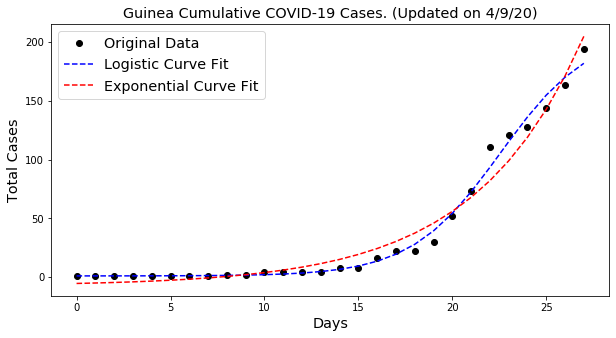



Sri Lanka

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 190
	Confirmed cases on 4/2/20 	 151
	Ratio: 1.26
	Weekly increase: 25.8 %
	Daily increase: 3.3 % per day
	Doubling Time (represents recent growth): 21.1 days

** Based on Logistic Fit**

	R^2: 0.9877576685805546
	Doubling Time (during middle of growth):  7.86 (± 0.97 ) days
	param:  [ 2.75775438e+04  1.76360603e-01 -1.23566034e+00  1.96291301e+02]

** Based on Exponential Fit **

	R^2: 0.9522442167414341
	Doubling Time (represents overall growth):  11.3 (± 1.46 ) days
	param:  [  2.65387272   0.06133873 -11.35052989]


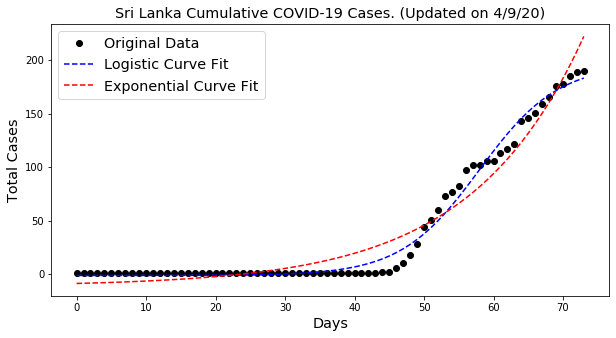



Kosovo

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 184
	Confirmed cases on 4/2/20 	 125
	Ratio: 1.47
	Weekly increase: 47.2 %
	Daily increase: 5.7 % per day
	Doubling Time (represents recent growth): 12.5 days

** Based on Logistic Fit**

	R^2: 0.9726028291341053
	Doubling Time (during middle of growth):  28.21 (± 336.8 ) days
	param:  [ 2.09734575e+05  4.91388731e-02 -3.38837096e+01  2.32169101e+07]

** Based on Exponential Fit **

	R^2: 0.9725583567206603
	Doubling Time (represents overall growth):  13.12 (± 12.49 ) days
	param:  [ 1.00000000e+02  5.28335144e-02 -2.27500675e+01]


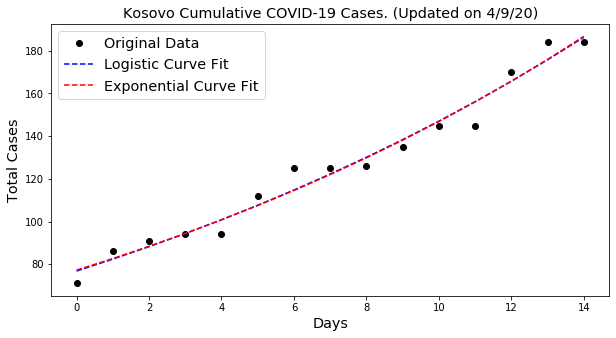



Kenya

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 184
	Confirmed cases on 4/2/20 	 110
	Ratio: 1.67
	Weekly increase: 67.3 %
	Daily increase: 7.6 % per day
	Doubling Time (represents recent growth): 9.4 days

** Based on Logistic Fit**

	R^2: 0.9933219623419703
	Doubling Time (during middle of growth):  4.91 (± 0.84 ) days
	param:  [3.58366957e+02 2.82120554e-01 3.39451713e+00 2.20112667e+02]

** Based on Exponential Fit **

	R^2: 0.9774919100557061
	Doubling Time (represents overall growth):  7.07 (± 1.4 ) days
	param:  [ 16.15672973   0.09802799 -22.8656884 ]


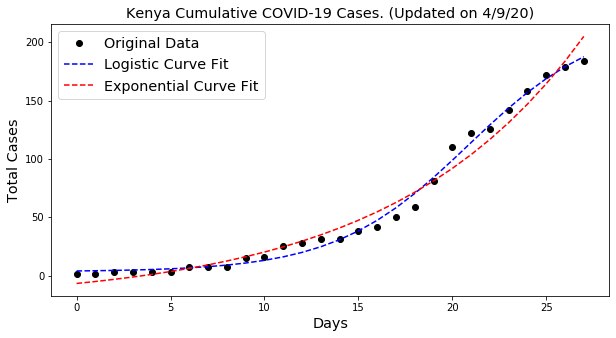



Congo (Kinshasa)

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 180
	Confirmed cases on 4/2/20 	 134
	Ratio: 1.34
	Weekly increase: 34.3 %
	Daily increase: 4.3 % per day
	Doubling Time (represents recent growth): 16.4 days

** Based on Logistic Fit**

	R^2: 0.9921166745408154
	Doubling Time (during middle of growth):  6.98 (± 1.42 ) days
	param:  [ 6.52812649e+01  1.98654600e-01 -3.38844954e+00  2.26752910e+02]

** Based on Exponential Fit **

	R^2: 0.9802956021210296
	Doubling Time (represents overall growth):  11.72 (± 2.95 ) days
	param:  [ 46.60846965   0.05912238 -57.20049225]


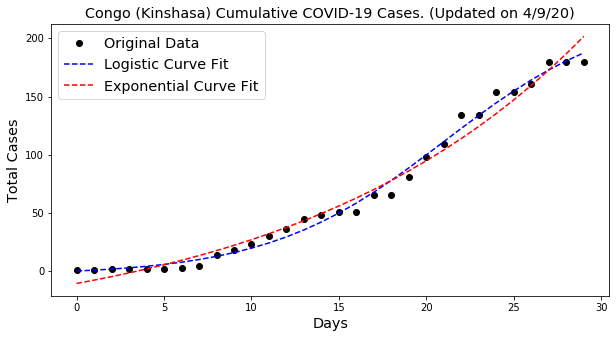



Venezuela

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 171
	Confirmed cases on 4/2/20 	 146
	Ratio: 1.17
	Weekly increase: 17.1 %
	Daily increase: 2.3 % per day
	Doubling Time (represents recent growth): 30.7 days

** Based on Logistic Fit**

	R^2: 0.9954495923119016
	Doubling Time (during middle of growth):  10.5 (± 3.0 ) days
	param:  [ 2.44792619e+00  1.32062511e-01 -7.30822003e+01  1.90434277e+02]

 exponential R^2  0.920965704008887


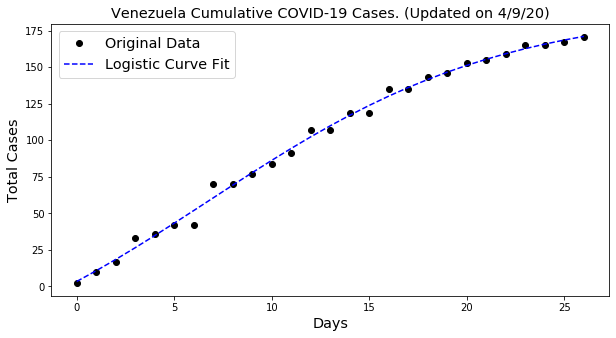



Djibouti

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 135
	Confirmed cases on 4/2/20 	 40
	Ratio: 3.38
	Weekly increase: 237.5 %
	Daily increase: 19.0 % per day
	Doubling Time (represents recent growth): 4.0 days

** Based on Logistic Fit**

	R^2: 0.9825896603788584
	Doubling Time (during middle of growth):  7.34 (± 4.22 ) days
	param:  [ 8.76400578e+02  1.88773593e-01 -2.04299654e+00  2.12718775e+03]

** Based on Exponential Fit **

	R^2: 0.9825641931926999
	Doubling Time (represents overall growth):  3.85 (± 0.58 ) days
	param:  [ 2.76517935  0.18002558 -2.64866766]


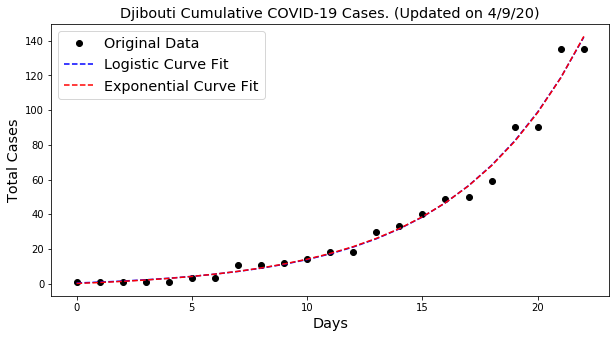



Brunei

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 135
	Confirmed cases on 4/2/20 	 133
	Ratio: 1.02
	Weekly increase: 1.5 %
	Daily increase: 0.2 % per day
	Doubling Time (represents recent growth): 325.1 days

** Based on Logistic Fit**

	R^2: 0.9930871765197572
	Doubling Time (during middle of growth):  9.49 (± 2.24 ) days
	param:  [  2.02232337   0.14608656 -73.79602127 143.19389602]

 exponential R^2  0.8417760508806308


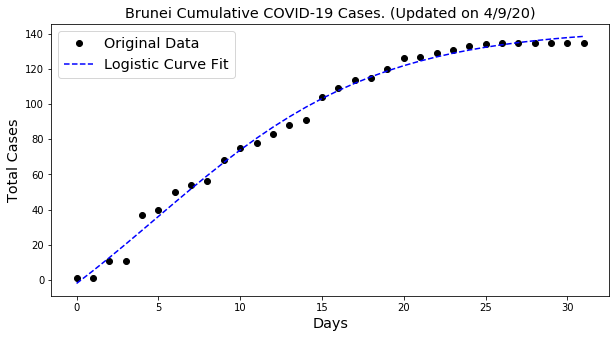



Paraguay

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 124
	Confirmed cases on 4/2/20 	 77
	Ratio: 1.61
	Weekly increase: 61.0 %
	Daily increase: 7.0 % per day
	Doubling Time (represents recent growth): 10.2 days

** Based on Logistic Fit**

	R^2: 0.9945869321696563
	Doubling Time (during middle of growth):  8.35 (± 1.45 ) days
	param:  [ 58.99206988   0.16596985  -1.86881831 161.75310334]

** Based on Exponential Fit **

	R^2: 0.9862316205417057
	Doubling Time (represents overall growth):  11.35 (± 2.03 ) days
	param:  [ 22.80963954   0.06105188 -27.25981841]


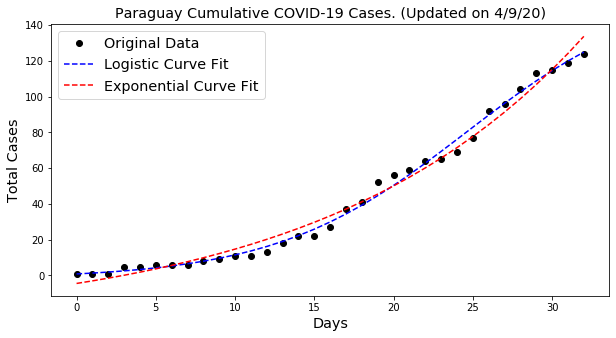



Cambodia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 119
	Confirmed cases on 4/2/20 	 110
	Ratio: 1.08
	Weekly increase: 8.2 %
	Daily increase: 1.1 % per day
	Doubling Time (represents recent growth): 61.7 days

** Based on Logistic Fit**

	R^2: 0.9950210719153192
	Doubling Time (during middle of growth):  3.52 (± 0.32 ) days
	param:  [1.38536468e+09 3.93322222e-01 7.47656930e-01 1.12317944e+02]

 exponential R^2  0.8859470490498595


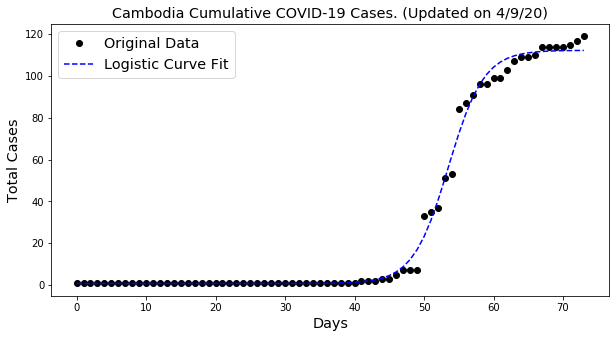



Rwanda

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 110
	Confirmed cases on 4/2/20 	 84
	Ratio: 1.31
	Weekly increase: 31.0 %
	Daily increase: 3.9 % per day
	Doubling Time (represents recent growth): 18.0 days

** Based on Logistic Fit**

	R^2: 0.9939140227703646
	Doubling Time (during middle of growth):  7.49 (± 1.62 ) days
	param:  [ 11.77153359   0.18497688 -11.34462504 123.01598346]

** Based on Exponential Fit **

	R^2: 0.9735918387510478
	Doubling Time (represents overall growth):  22.22 (± 13.86 ) days
	param:  [ 1.00000000e+02  3.11932821e-02 -1.00000000e+02]


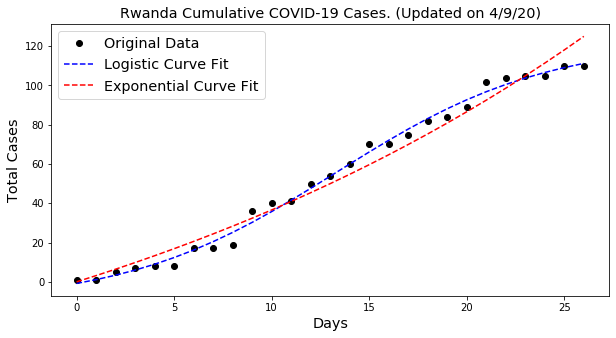



Trinidad and Tobago

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 109
	Confirmed cases on 4/2/20 	 94
	Ratio: 1.16
	Weekly increase: 16.0 %
	Daily increase: 2.1 % per day
	Doubling Time (represents recent growth): 32.8 days

** Based on Logistic Fit**

	R^2: 0.9733668639381847
	Doubling Time (during middle of growth):  7.52 (± 3.5 ) days
	param:  [  4.71547807   0.18442585 -29.92167688 113.35293947]

 exponential R^2  0.9018729833581293


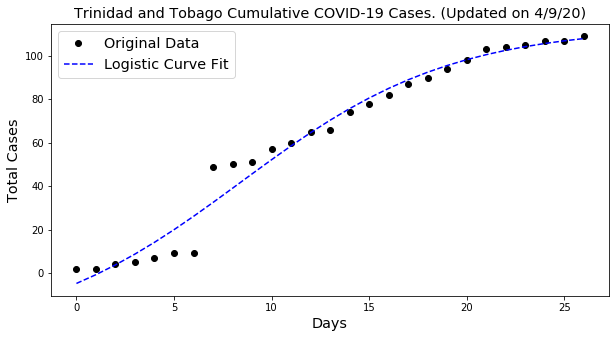



El Salvador

** Based on Most Recent Week of Data **

	Confirmed cases on 4/9/20 	 103
	Confirmed cases on 4/2/20 	 41
	Ratio: 2.51
	Weekly increase: 151.2 %
	Daily increase: 14.1 % per day
	Doubling Time (represents recent growth): 5.3 days

** Based on Logistic Fit**

	R^2: 0.9964096632845632
	Doubling Time (during middle of growth):  12.52 (± 7.8 ) days
	param:  [ 7.53062556e+06  1.10768498e-01 -1.20739865e+01  8.46501334e+07]

** Based on Exponential Fit **

	R^2: 0.9964096635161859
	Doubling Time (represents overall growth):  6.26 (± 0.61 ) days
	param:  [ 11.24080317   0.11076841 -12.07400133]


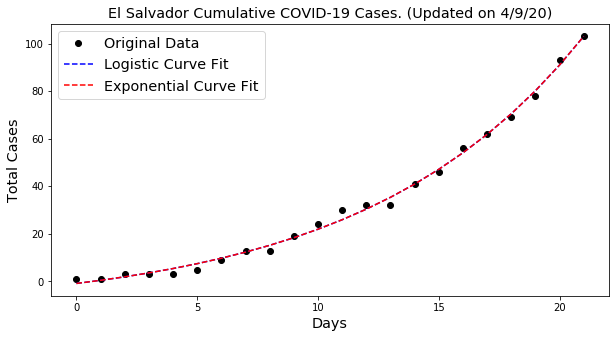

In [6]:
topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
print('\n')

cnames = topcountries.values

for c in cnames:
    print(c)
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for Global COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


     Inferred Doubling Time  95%CI  Recent Doubling Time
0                       6.5    0.2                   7.6
1                       6.8    0.2                  15.5
2                       8.8    0.3                  22.0
3                       8.9    0.7                   7.1
4                       7.3    0.2                  14.6
5                       6.6    0.5                 889.3
6                      14.9    1.7                  17.9
7                       7.1    0.1                   7.4
8                       6.4    0.6                   5.7
9                       7.0    0.3                  10.0
10                      7.4    0.5                  19.8
11                      8.0    0.3                  12.4
12                      6.8    0.2                 

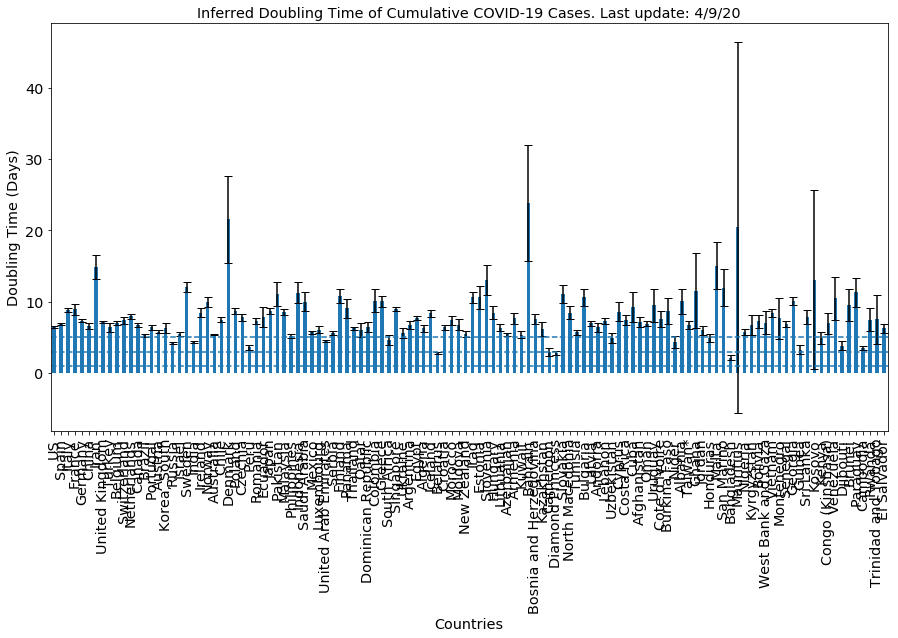

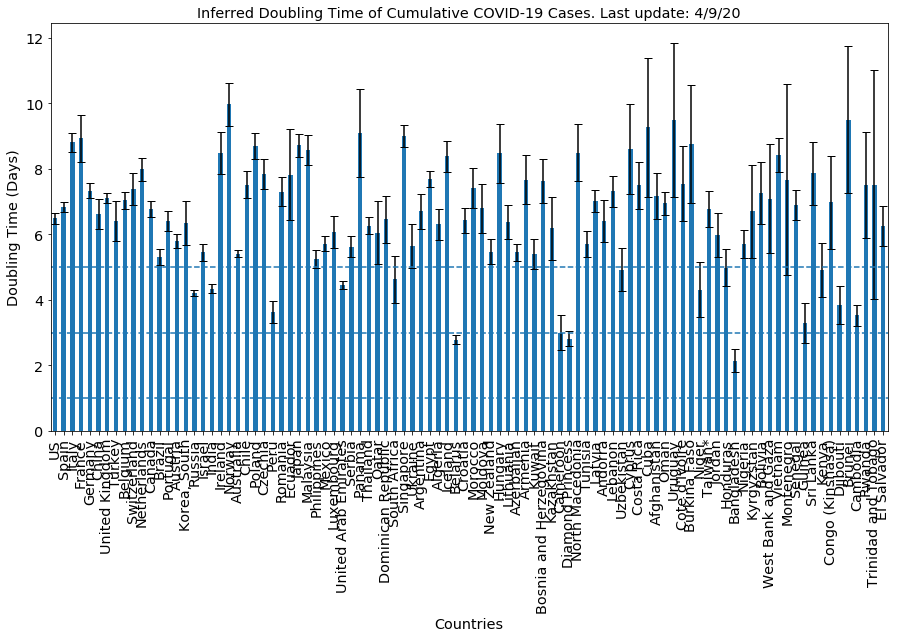

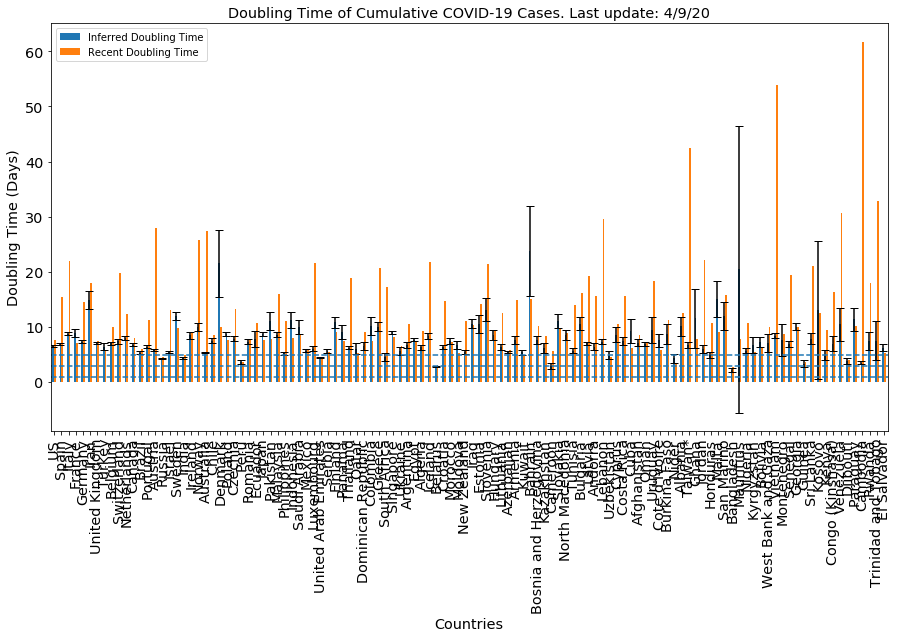

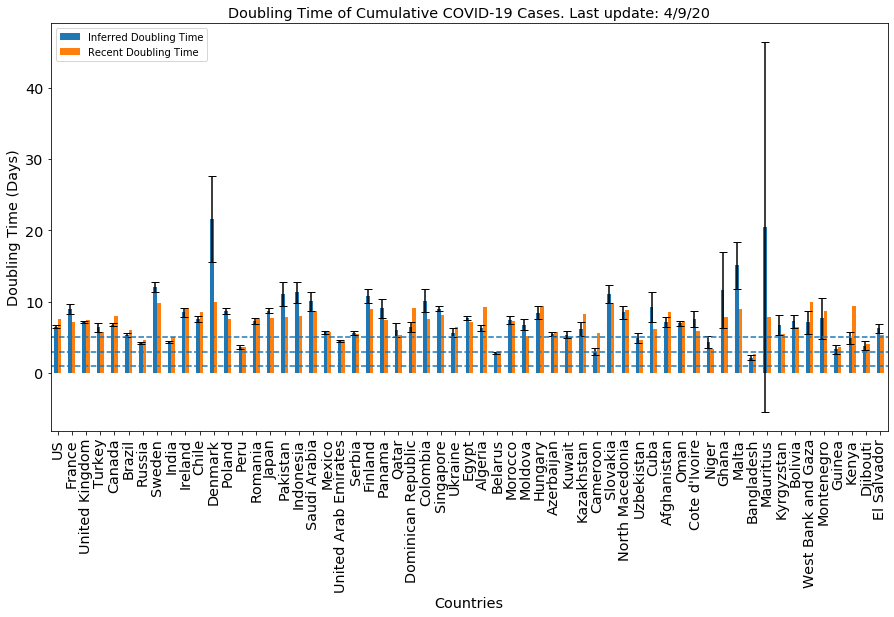

In [7]:
d = {'Countries': countries, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')

print(pd.DataFrame(data=d).iloc[:,[1,2,3]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 10]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=countries
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 10]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()